In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12123.25it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty, ClipEnvNoCuriosity
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [9]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        if (upd + 1) % 10 == 0:
            save_actor_critic(actor_critic, f"chkpoint_{upd}.pt")
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [10]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnvNoCuriosity(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=84.2353, Policy=0.0018, Value=168.6345
[PPO] Epoch 10: Loss=65.2453, Policy=-0.0031, Value=130.6658
[PPO] Epoch 20: Loss=53.1100, Policy=0.0086, Value=106.3664
[PPO] Epoch 30: Loss=44.9438, Policy=-0.0070, Value=90.0711
Approx KL Learned: 0.015477476641535759
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/100 — steps: 4096


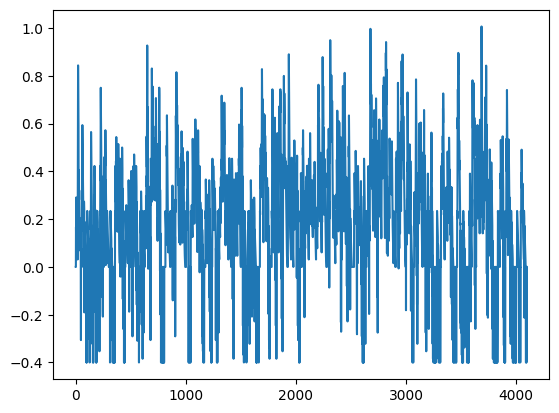

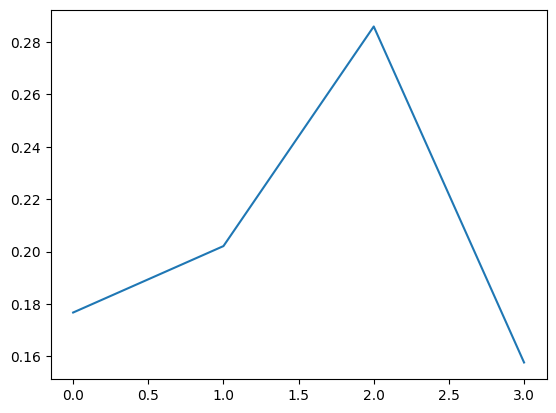

[PPO] Epoch 0: Loss=91.1729, Policy=0.0001, Value=182.5167
[PPO] Epoch 10: Loss=74.4958, Policy=-0.0015, Value=149.1663
[PPO] Epoch 20: Loss=63.7030, Policy=-0.0036, Value=127.5846
[PPO] Epoch 30: Loss=56.9494, Policy=-0.0090, Value=114.0874
Approx KL Learned: 0.01197195053100586
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/100 — steps: 4096


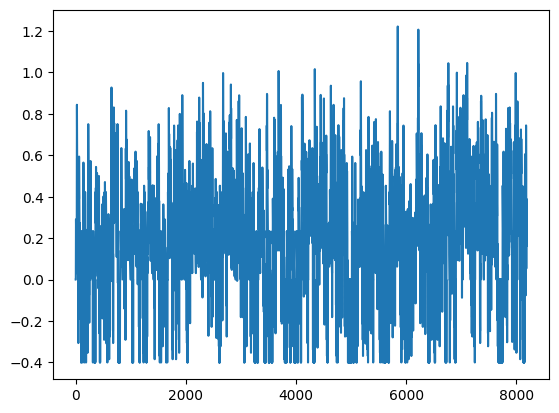

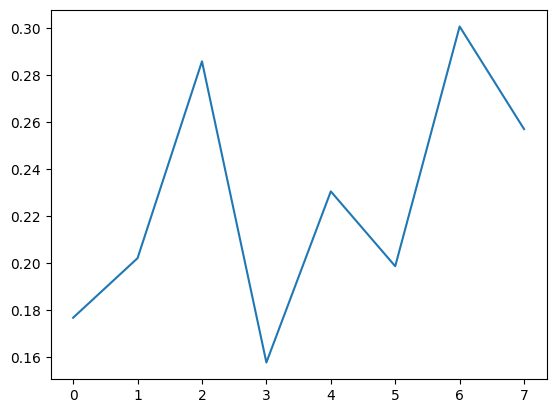

[PPO] Epoch 0: Loss=94.6023, Policy=0.0018, Value=189.3704
[PPO] Epoch 10: Loss=85.5412, Policy=0.0004, Value=171.2510
[PPO] Epoch 20: Loss=79.8910, Policy=-0.0048, Value=159.9616
[PPO] Epoch 30: Loss=76.7381, Policy=-0.0055, Value=153.6574
Approx KL Learned: 0.010035520419478416
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/100 — steps: 4096


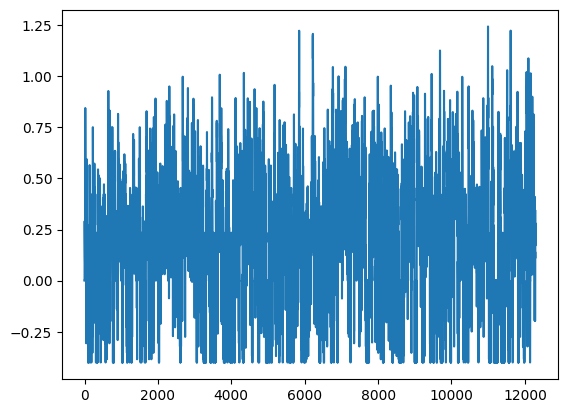

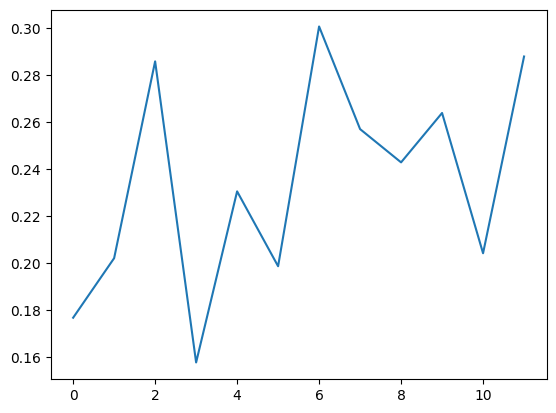

[PPO] Epoch 0: Loss=83.1756, Policy=0.0036, Value=166.5143
[PPO] Epoch 10: Loss=68.5029, Policy=-0.0037, Value=137.1823
[PPO] Epoch 20: Loss=53.7117, Policy=-0.0061, Value=107.6060
[PPO] Epoch 30: Loss=43.3055, Policy=-0.0073, Value=86.7967
Approx KL Learned: 0.015870384871959686
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/100 — steps: 4096


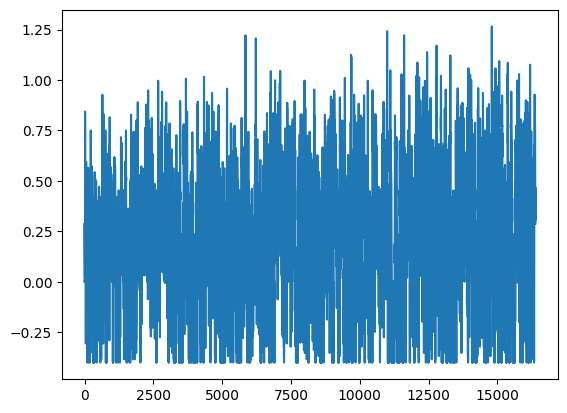

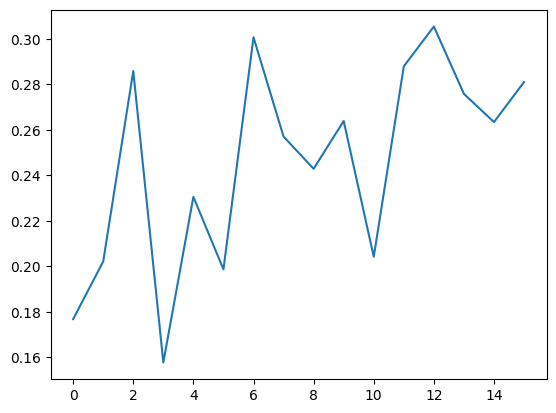

[PPO] Epoch 0: Loss=71.3407, Policy=-0.0014, Value=142.8340
[PPO] Epoch 10: Loss=61.7921, Policy=-0.0015, Value=123.7336
[PPO] Epoch 20: Loss=53.6875, Policy=-0.0015, Value=107.5227
[PPO] Epoch 30: Loss=48.4427, Policy=-0.0063, Value=97.0603
Approx KL Learned: 0.012458736076951027
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/100 — steps: 4096


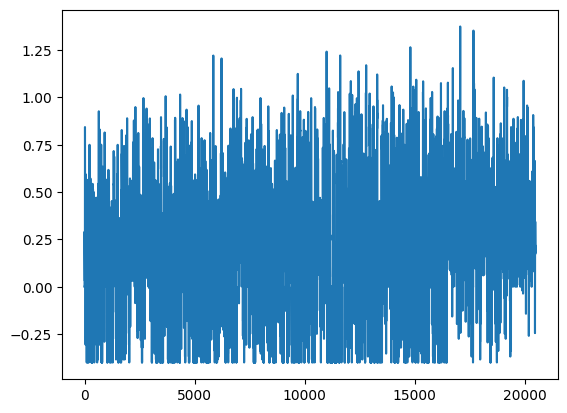

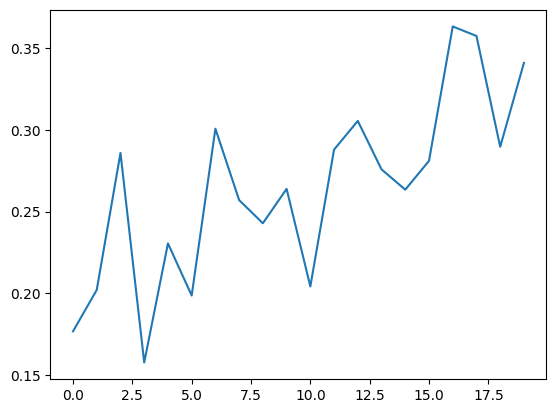

[PPO] Epoch 0: Loss=66.7655, Policy=0.0008, Value=133.6848
[PPO] Epoch 10: Loss=54.4276, Policy=-0.0064, Value=109.0236
[PPO] Epoch 20: Loss=48.3394, Policy=-0.0130, Value=96.8649
[PPO] Epoch 30: Loss=44.0317, Policy=-0.0134, Value=88.2499
Approx KL Learned: 0.014647156000137329
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/100 — steps: 4096


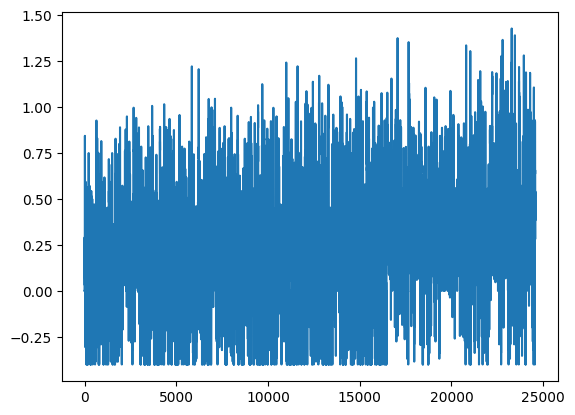

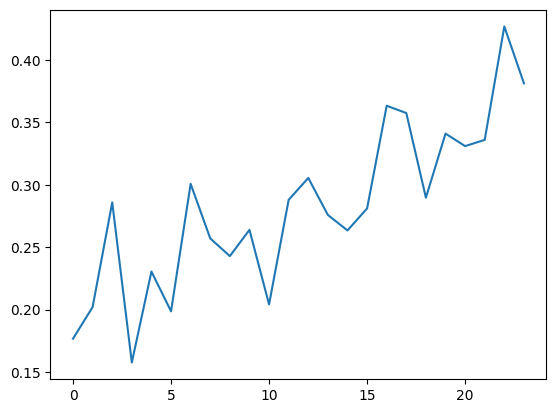

[PPO] Epoch 0: Loss=62.1139, Policy=0.0012, Value=124.3871
[PPO] Epoch 10: Loss=50.5977, Policy=-0.0097, Value=101.3737
[PPO] Epoch 20: Loss=42.4259, Policy=-0.0170, Value=85.0454
[PPO] Epoch 30: Loss=37.3015, Policy=-0.0205, Value=74.8036
Approx KL Learned: 0.01980108767747879
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/100 — steps: 4096


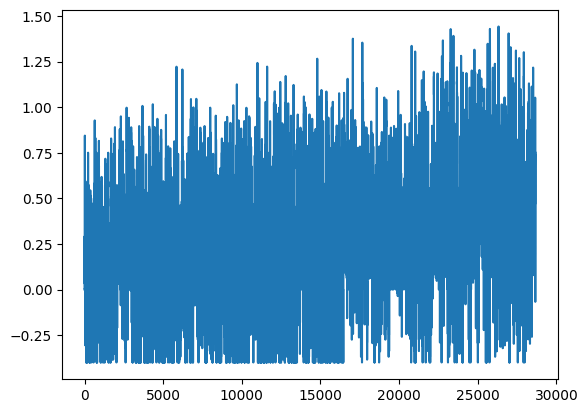

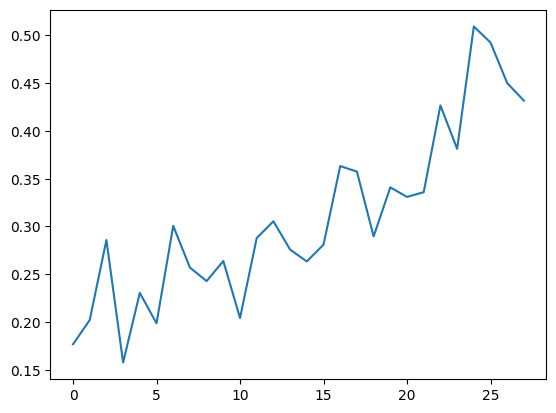

[PPO] Epoch 0: Loss=80.1224, Policy=-0.0008, Value=160.4065
[PPO] Epoch 10: Loss=54.5718, Policy=-0.0058, Value=109.3100
[PPO] Epoch 20: Loss=44.7389, Policy=-0.0157, Value=89.6647
[PPO] Epoch 30: Loss=38.7693, Policy=-0.0183, Value=77.7296
Approx KL Learned: 0.01456882618367672
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/100 — steps: 4096


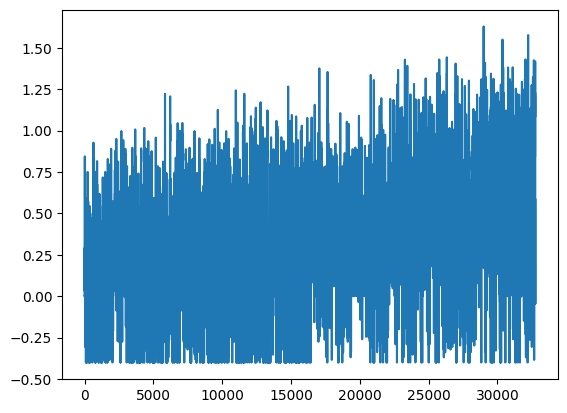

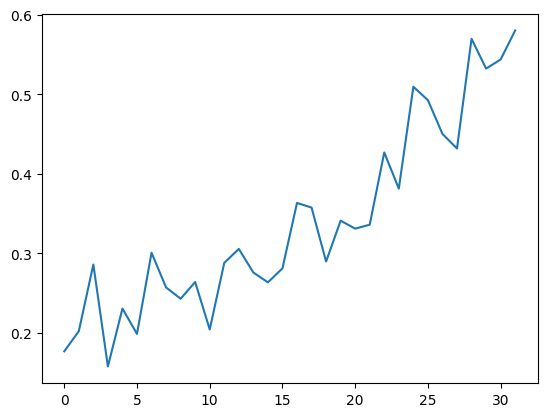

[PPO] Epoch 0: Loss=93.3570, Policy=0.0002, Value=186.8680
[PPO] Epoch 10: Loss=73.0859, Policy=-0.0051, Value=146.3329
[PPO] Epoch 20: Loss=58.6672, Policy=-0.0125, Value=117.5106
[PPO] Epoch 30: Loss=51.1372, Policy=-0.0185, Value=102.4626
Approx KL Learned: 0.0164291150867939
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/100 — steps: 4096


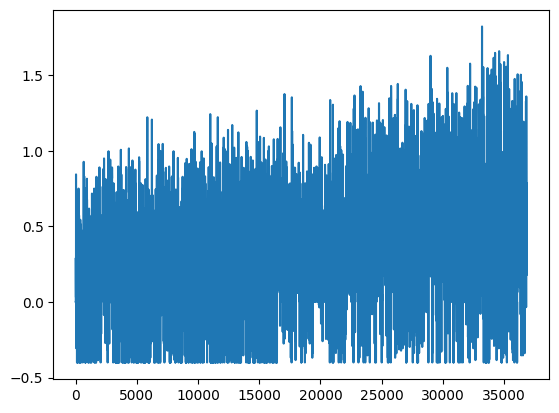

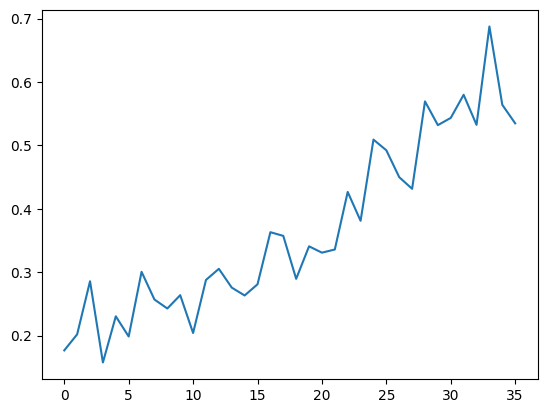

[PPO] Epoch 0: Loss=85.0342, Policy=0.0024, Value=170.2145
[PPO] Epoch 10: Loss=65.5160, Policy=-0.0078, Value=131.1971
[PPO] Epoch 20: Loss=56.6555, Policy=-0.0176, Value=113.4935
[PPO] Epoch 30: Loss=52.9126, Policy=-0.0078, Value=105.9910
Approx KL Learned: 0.017665540799498558
[✅] Actor-Critic checkpoint saved to chkpoint_9.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/100 — steps: 4096


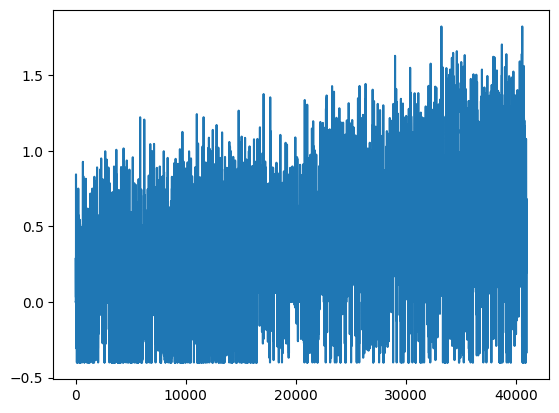

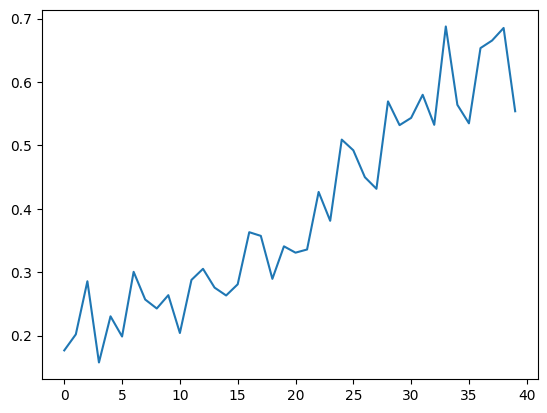

[PPO] Epoch 0: Loss=104.5961, Policy=0.0028, Value=209.3377
[PPO] Epoch 10: Loss=80.4367, Policy=-0.0028, Value=161.0285
[PPO] Epoch 20: Loss=74.2397, Policy=-0.0144, Value=148.6563
[PPO] Epoch 30: Loss=66.3732, Policy=-0.0225, Value=132.9404
Approx KL Learned: 0.019923102110624313
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 11/100 — steps: 4096


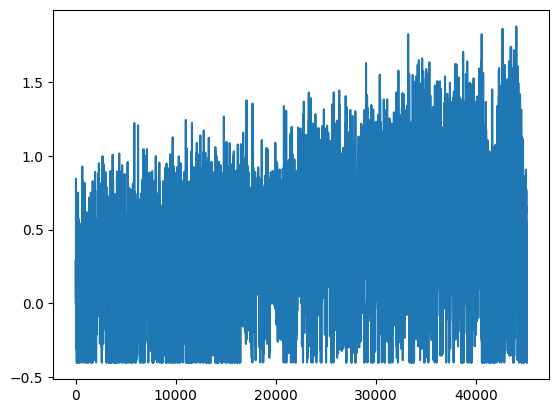

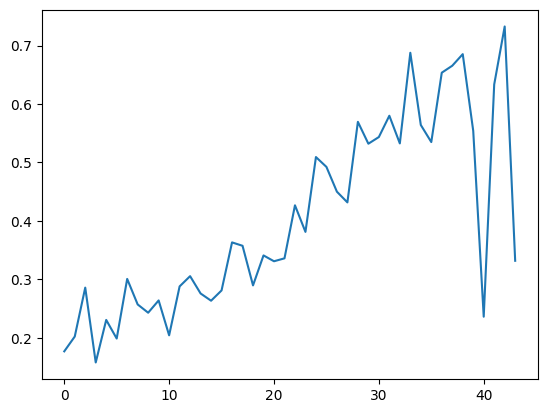

[PPO] Epoch 0: Loss=113.7431, Policy=0.0027, Value=227.6390
[PPO] Epoch 10: Loss=82.7312, Policy=-0.0045, Value=165.6319
[PPO] Epoch 20: Loss=62.8910, Policy=-0.0150, Value=125.9722
[PPO] Epoch 30: Loss=53.6595, Policy=-0.0204, Value=107.5211
Approx KL Learned: 0.025552406907081604
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 12/100 — steps: 4096


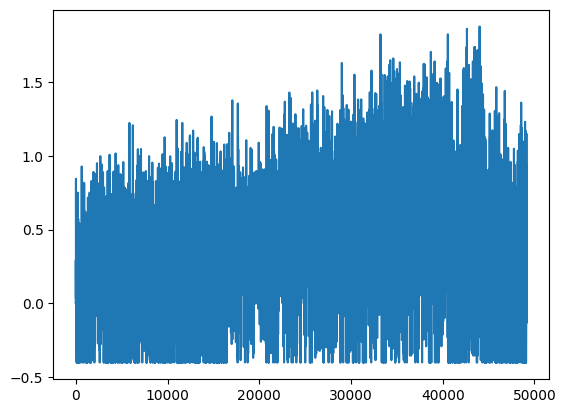

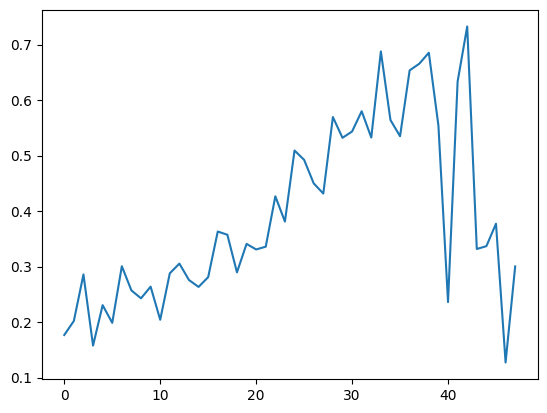

[PPO] Epoch 0: Loss=98.1463, Policy=0.0051, Value=196.4382
[PPO] Epoch 10: Loss=68.1824, Policy=0.0037, Value=136.5161
[PPO] Epoch 20: Loss=52.0431, Policy=-0.0108, Value=104.2599
[PPO] Epoch 30: Loss=43.6287, Policy=-0.0170, Value=87.4434
Approx KL Learned: 0.025461580604314804
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 13/100 — steps: 4096


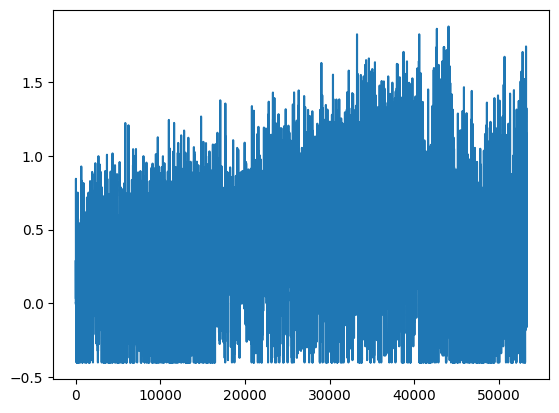

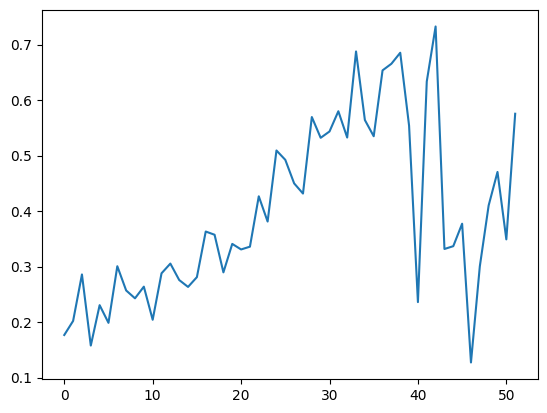

[PPO] Epoch 0: Loss=109.0853, Policy=0.0000, Value=218.3260
[PPO] Epoch 10: Loss=90.2355, Policy=0.0028, Value=180.6061
[PPO] Epoch 20: Loss=78.3971, Policy=-0.0044, Value=156.9610
[PPO] Epoch 30: Loss=71.0732, Policy=-0.0172, Value=142.3308
Approx KL Learned: 0.019380157813429832
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 14/100 — steps: 4096


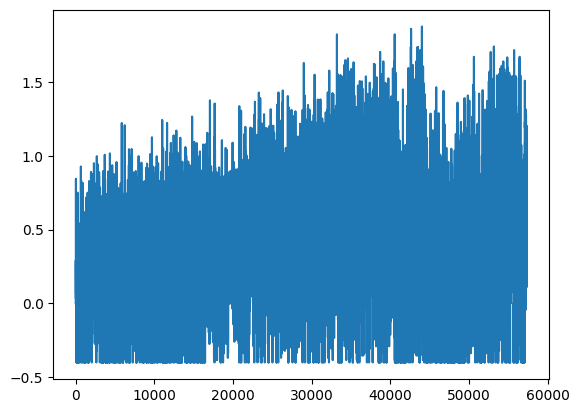

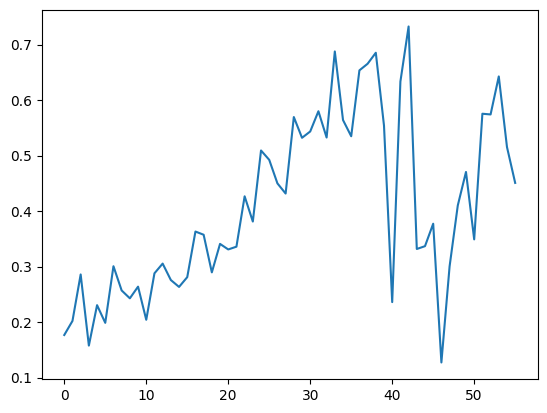

[PPO] Epoch 0: Loss=100.6605, Policy=0.0006, Value=201.4831
[PPO] Epoch 10: Loss=70.2165, Policy=-0.0071, Value=140.6076
[PPO] Epoch 20: Loss=58.2691, Policy=-0.0148, Value=116.7285
[PPO] Epoch 30: Loss=53.0161, Policy=-0.0212, Value=106.2355
Approx KL Learned: 0.02256213314831257
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 15/100 — steps: 4096


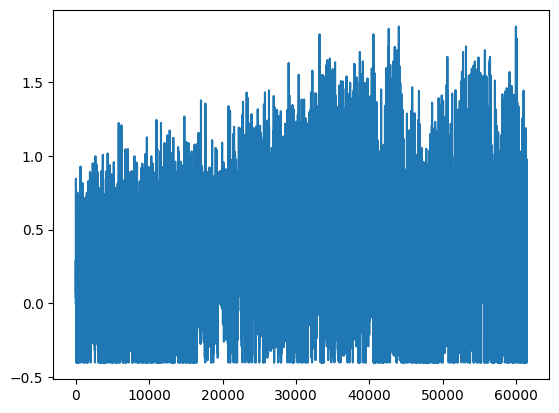

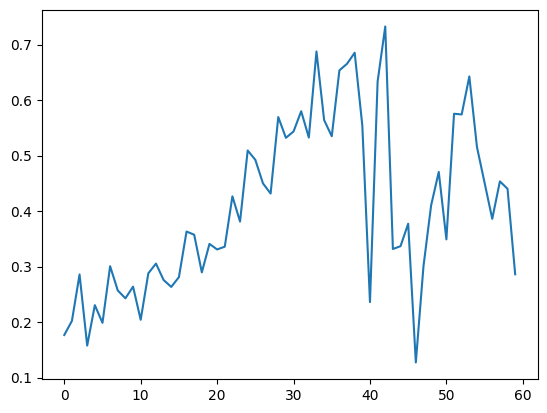

[PPO] Epoch 0: Loss=67.4478, Policy=0.0047, Value=135.0284
[PPO] Epoch 10: Loss=53.5037, Policy=-0.0110, Value=107.1618
[PPO] Epoch 20: Loss=43.4502, Policy=-0.0177, Value=87.0652
[PPO] Epoch 30: Loss=35.0567, Policy=0.0007, Value=70.2576
Approx KL Learned: 0.045930102467536926
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 16/100 — steps: 4096


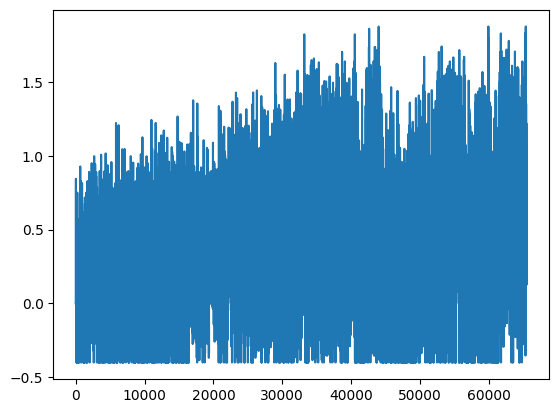

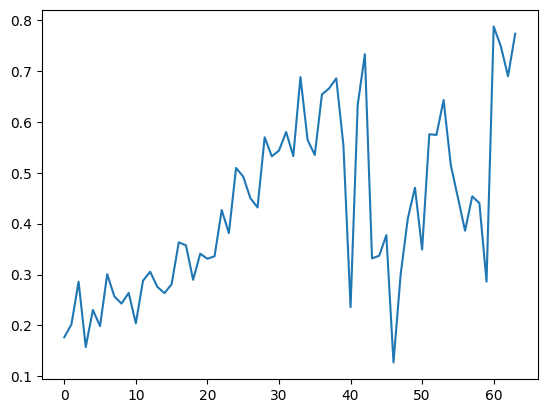

[PPO] Epoch 0: Loss=65.4707, Policy=0.0015, Value=131.0793
[PPO] Epoch 10: Loss=51.7644, Policy=0.0142, Value=103.6464
[PPO] Epoch 20: Loss=41.2368, Policy=-0.0071, Value=82.6167
[PPO] Epoch 30: Loss=32.8474, Policy=-0.0138, Value=65.8553
Approx KL Learned: 0.01555207185447216
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 17/100 — steps: 4096


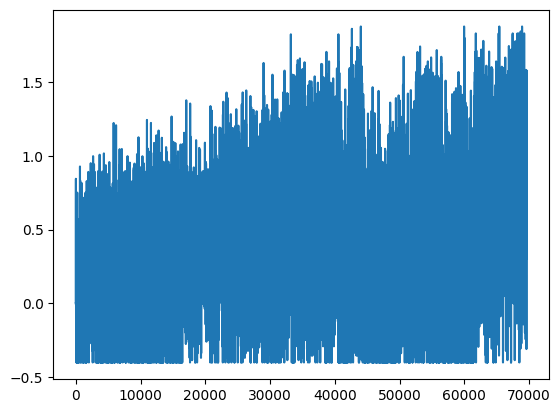

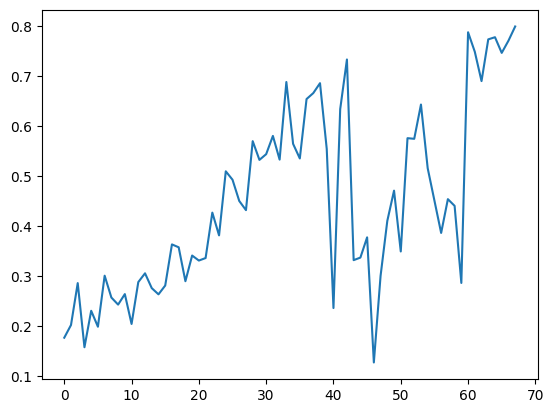

[PPO] Epoch 0: Loss=112.2490, Policy=0.0052, Value=224.6293
[PPO] Epoch 10: Loss=68.2498, Policy=0.0017, Value=136.6346
[PPO] Epoch 20: Loss=59.6966, Policy=-0.0108, Value=119.5512
[PPO] Epoch 30: Loss=54.6423, Policy=-0.0149, Value=109.4507
Approx KL Learned: 0.018743958324193954
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 18/100 — steps: 4096


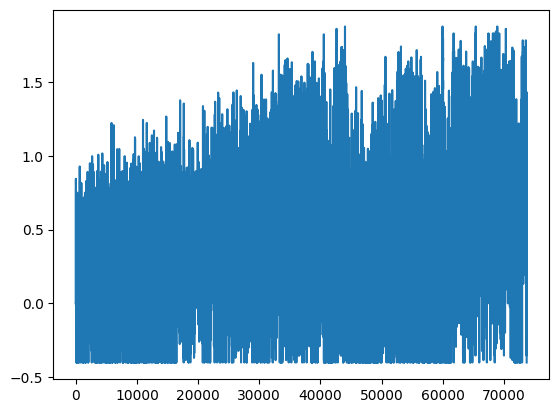

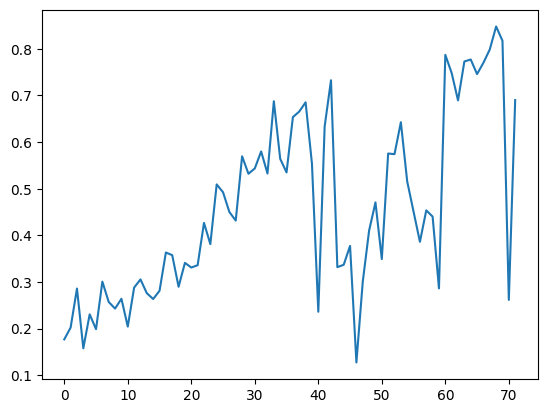

[PPO] Epoch 0: Loss=57.4403, Policy=0.0033, Value=114.9948
[PPO] Epoch 10: Loss=44.1680, Policy=-0.0054, Value=88.4661
[PPO] Epoch 20: Loss=36.8899, Policy=-0.0161, Value=73.9286
[PPO] Epoch 30: Loss=31.6508, Policy=-0.0202, Value=63.4594
Approx KL Learned: 0.027367038652300835
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 19/100 — steps: 4096


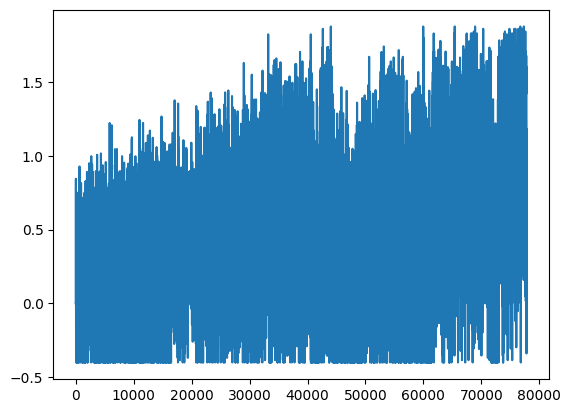

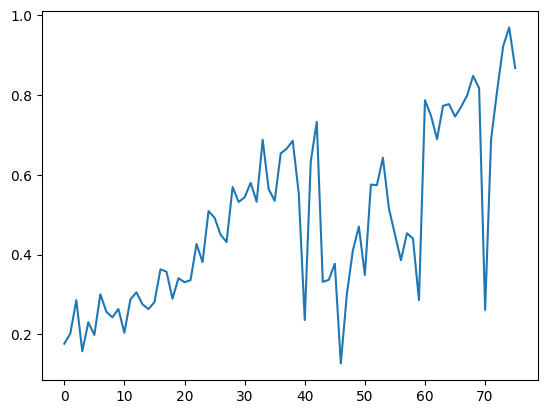

[PPO] Epoch 0: Loss=59.6449, Policy=0.0052, Value=119.3925
[PPO] Epoch 10: Loss=42.6537, Policy=-0.0035, Value=85.4222
[PPO] Epoch 20: Loss=31.8589, Policy=-0.0109, Value=63.8469
[PPO] Epoch 30: Loss=27.0826, Policy=-0.0176, Value=54.3098
Approx KL Learned: 0.01883396878838539
[✅] Actor-Critic checkpoint saved to chkpoint_19.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 20/100 — steps: 4096


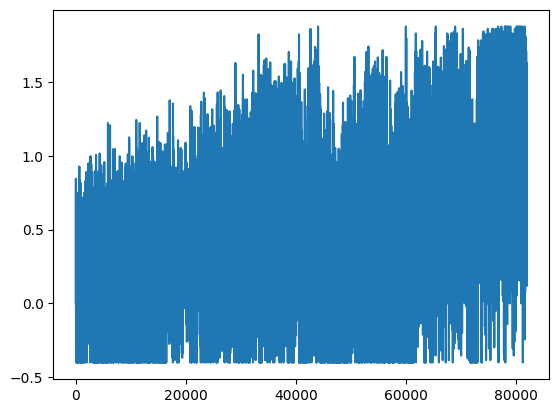

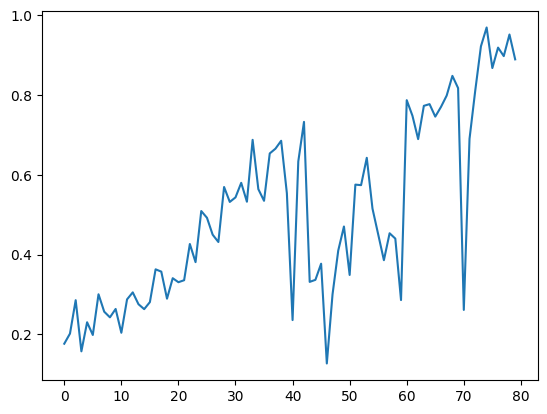

[PPO] Epoch 0: Loss=103.2679, Policy=0.0032, Value=206.6646
[PPO] Epoch 10: Loss=69.9682, Policy=0.0010, Value=140.0660
[PPO] Epoch 20: Loss=66.0883, Policy=-0.0138, Value=132.3355
[PPO] Epoch 30: Loss=61.6588, Policy=-0.0252, Value=123.4982
Approx KL Learned: 0.023179486393928528
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 21/100 — steps: 4096


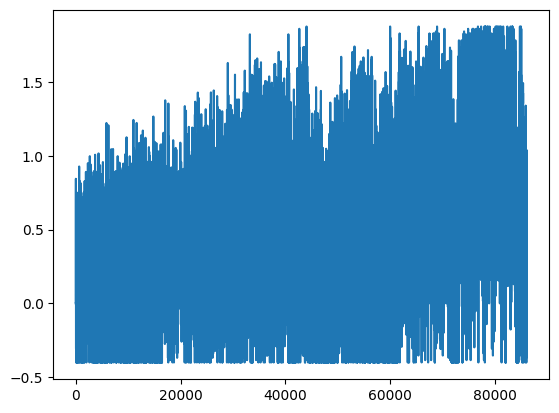

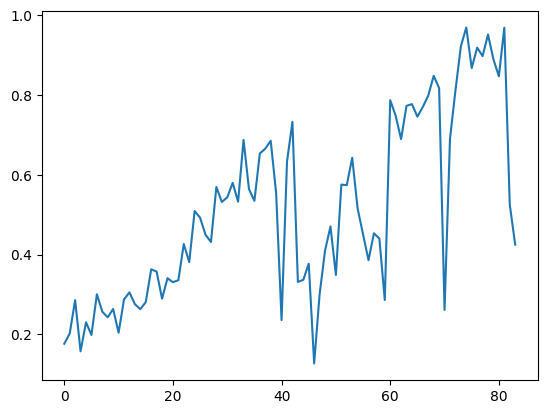

[PPO] Epoch 0: Loss=124.6995, Policy=0.0064, Value=249.5381
[PPO] Epoch 10: Loss=102.4964, Policy=-0.0129, Value=205.1698
[PPO] Epoch 20: Loss=90.2021, Policy=-0.0255, Value=180.6028
[PPO] Epoch 30: Loss=81.3102, Policy=-0.0379, Value=162.8443
Approx KL Learned: 0.036052241921424866
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 22/100 — steps: 4096


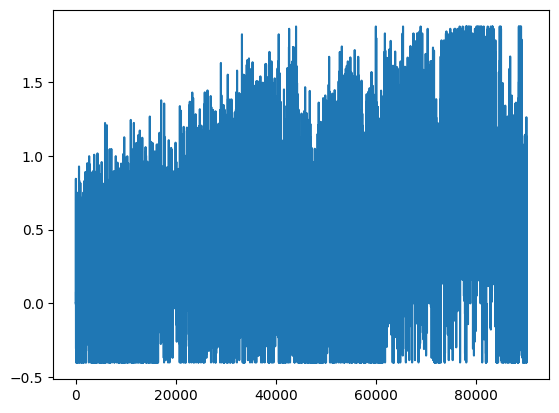

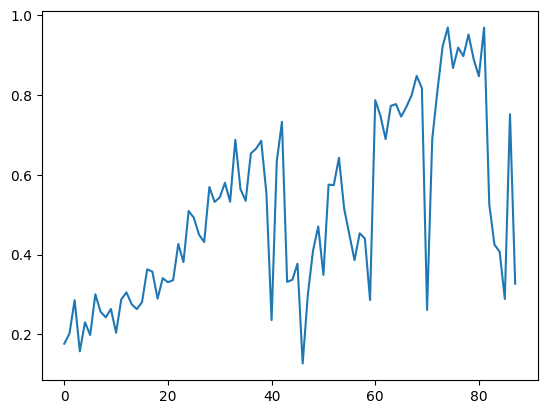

[PPO] Epoch 0: Loss=86.7231, Policy=0.0058, Value=173.5342
[PPO] Epoch 10: Loss=69.8266, Policy=-0.0011, Value=139.7521
[PPO] Epoch 20: Loss=58.9790, Policy=-0.0107, Value=118.0794
[PPO] Epoch 30: Loss=54.8438, Policy=-0.0244, Value=109.8360
Approx KL Learned: 0.04499594867229462
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 23/100 — steps: 4096


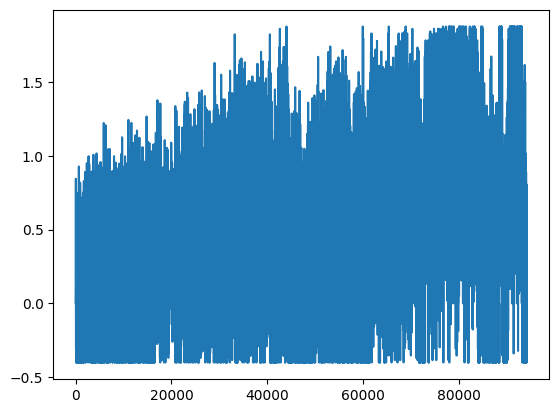

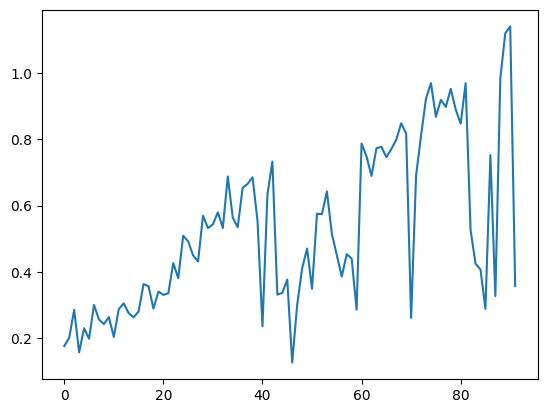

[PPO] Epoch 0: Loss=91.0191, Policy=0.0063, Value=182.1382
[PPO] Epoch 10: Loss=79.6768, Policy=-0.0102, Value=159.4822
[PPO] Epoch 20: Loss=72.6305, Policy=-0.0191, Value=145.4102
[PPO] Epoch 30: Loss=67.0742, Policy=-0.0276, Value=134.3135
Approx KL Learned: 0.044070228934288025
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 24/100 — steps: 4096


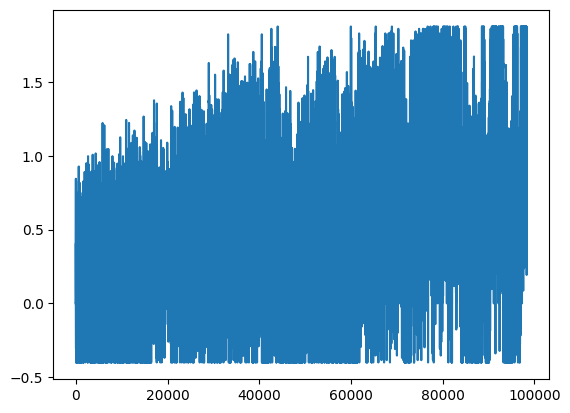

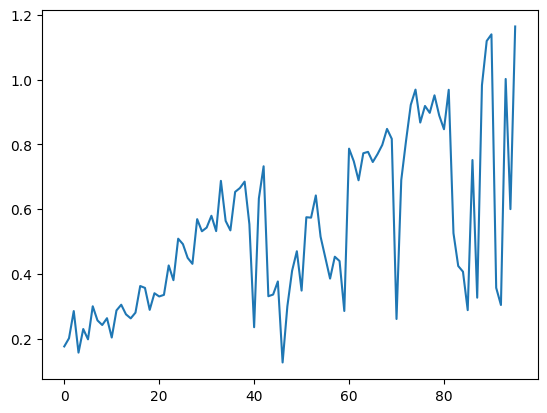

[PPO] Epoch 0: Loss=64.4696, Policy=0.0091, Value=128.9929
[PPO] Epoch 10: Loss=54.3631, Policy=-0.0088, Value=108.8182
[PPO] Epoch 20: Loss=49.7871, Policy=-0.0168, Value=99.6892
[PPO] Epoch 30: Loss=46.4462, Policy=-0.0281, Value=93.0266
Approx KL Learned: 0.05404728651046753
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 25/100 — steps: 4096


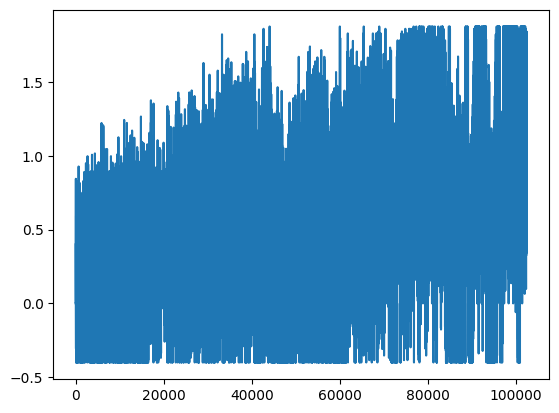

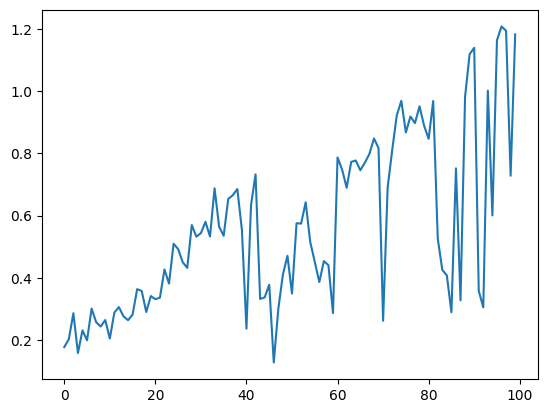

[PPO] Epoch 0: Loss=57.3415, Policy=0.0051, Value=114.7481
[PPO] Epoch 10: Loss=46.3750, Policy=-0.0059, Value=92.8325
[PPO] Epoch 20: Loss=41.6646, Policy=-0.0128, Value=83.4366
[PPO] Epoch 30: Loss=37.2686, Policy=-0.0213, Value=74.6616
Approx KL Learned: 0.0500437393784523
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 26/100 — steps: 4096


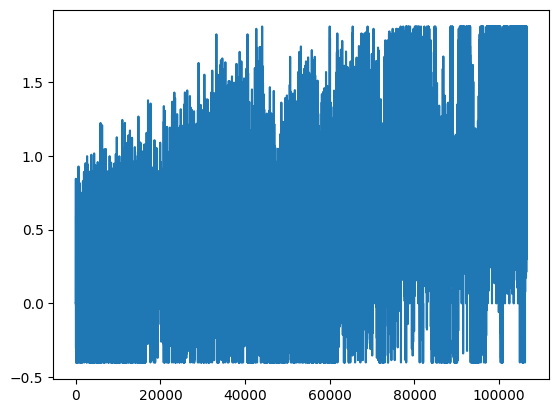

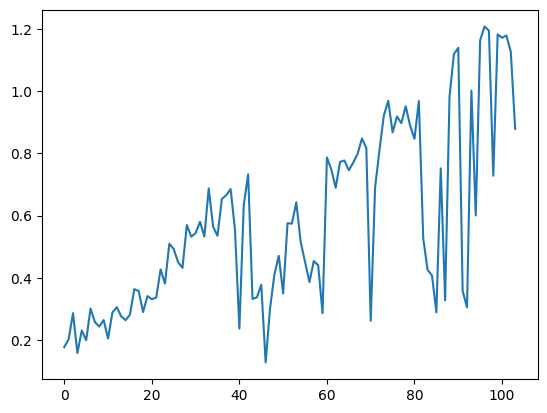

[PPO] Epoch 0: Loss=38.8687, Policy=0.0106, Value=77.7961
[PPO] Epoch 10: Loss=24.0701, Policy=-0.0059, Value=48.2307
[PPO] Epoch 20: Loss=20.9576, Policy=-0.0189, Value=42.0283
[PPO] Epoch 30: Loss=16.0214, Policy=-0.0251, Value=32.1682
Approx KL Learned: 0.07919659465551376
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 27/100 — steps: 4096


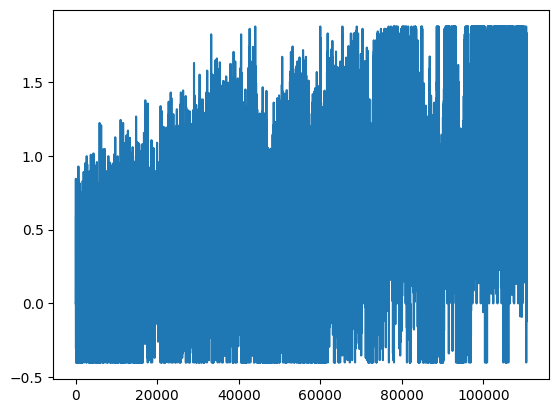

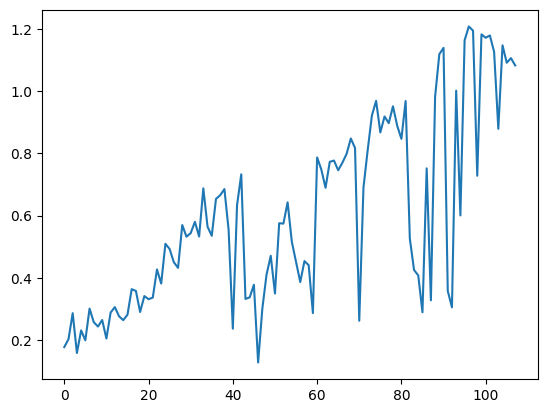

[PPO] Epoch 0: Loss=19.5514, Policy=0.0064, Value=39.1517
[PPO] Epoch 10: Loss=13.1497, Policy=0.0280, Value=26.2962
[PPO] Epoch 20: Loss=11.0485, Policy=0.0190, Value=22.1056
[PPO] Epoch 30: Loss=9.6932, Policy=0.0619, Value=19.2983
Approx KL Learned: 0.6350097060203552
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 28/100 — steps: 4096


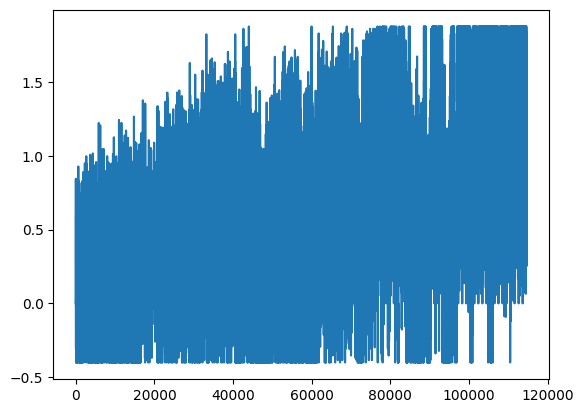

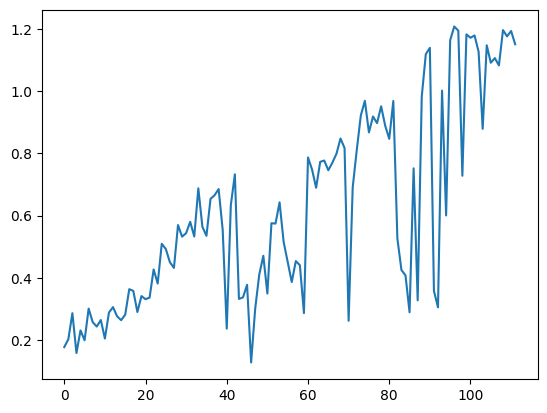

[PPO] Epoch 0: Loss=144.9834, Policy=0.0084, Value=290.0273
[PPO] Epoch 10: Loss=91.1384, Policy=0.0107, Value=182.3408
[PPO] Epoch 20: Loss=60.0274, Policy=0.0028, Value=120.1373
[PPO] Epoch 30: Loss=43.0322, Policy=0.0024, Value=86.1519
Approx KL Learned: 0.04547435790300369
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 29/100 — steps: 4096


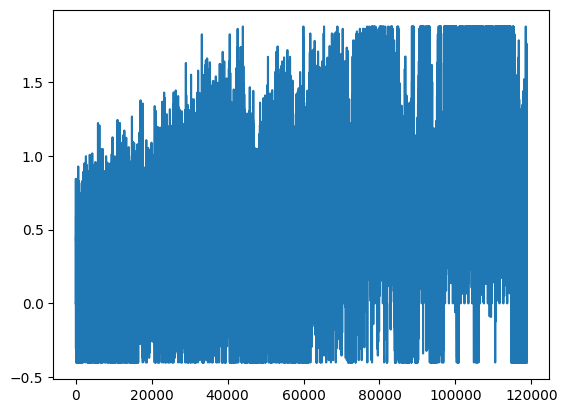

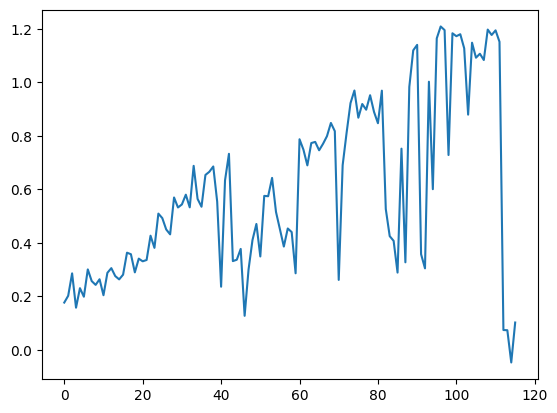

[PPO] Epoch 0: Loss=114.3028, Policy=0.0032, Value=228.6926
[PPO] Epoch 10: Loss=65.3649, Policy=0.0007, Value=130.8262
[PPO] Epoch 20: Loss=41.9765, Policy=-0.0042, Value=84.0656
[PPO] Epoch 30: Loss=37.1278, Policy=-0.0087, Value=74.3697
Approx KL Learned: 0.03645005449652672
[✅] Actor-Critic checkpoint saved to chkpoint_29.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 30/100 — steps: 4096


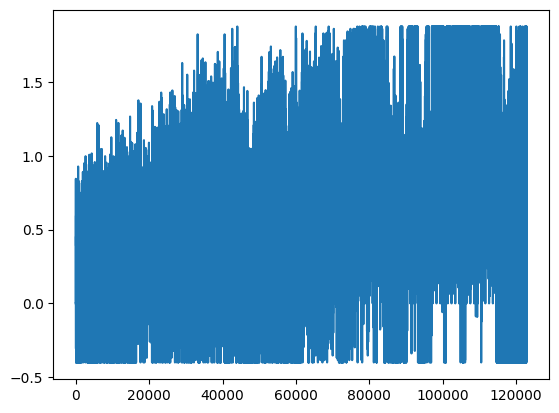

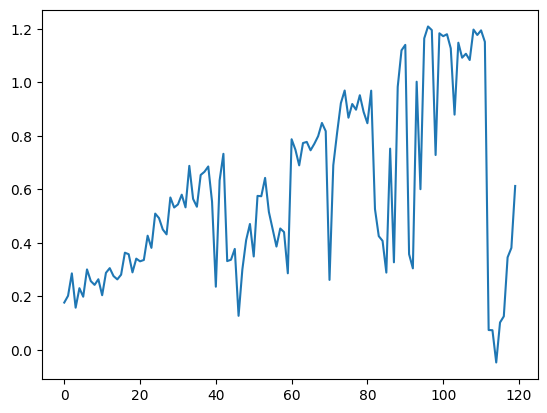

[PPO] Epoch 0: Loss=120.1340, Policy=0.0035, Value=240.3450
[PPO] Epoch 10: Loss=72.9888, Policy=0.0007, Value=146.0727
[PPO] Epoch 20: Loss=52.2730, Policy=-0.0025, Value=104.6506
[PPO] Epoch 30: Loss=36.4013, Policy=-0.0074, Value=72.9154
Approx KL Learned: 0.03353225067257881
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 31/100 — steps: 4096


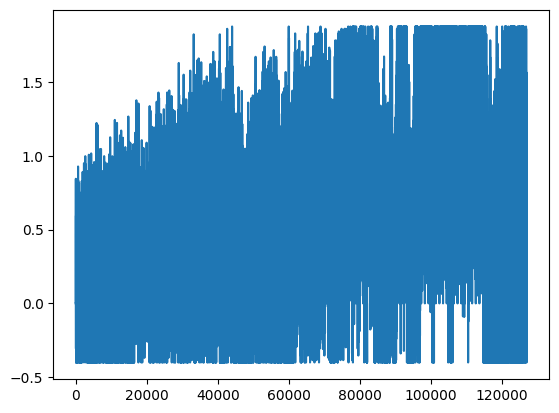

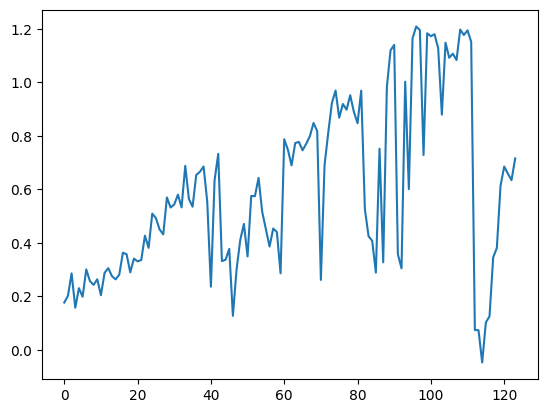

[PPO] Epoch 0: Loss=95.4967, Policy=-0.0012, Value=191.1160
[PPO] Epoch 10: Loss=62.2737, Policy=0.0013, Value=124.6675
[PPO] Epoch 20: Loss=52.2121, Policy=-0.0014, Value=104.5507
[PPO] Epoch 30: Loss=42.2164, Policy=-0.0072, Value=84.5706
Approx KL Learned: 0.01358101423829794
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 32/100 — steps: 4096


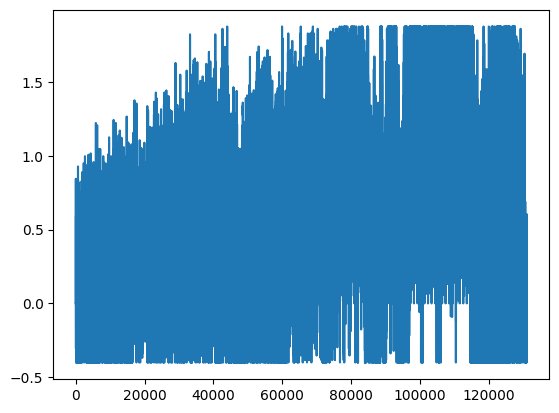

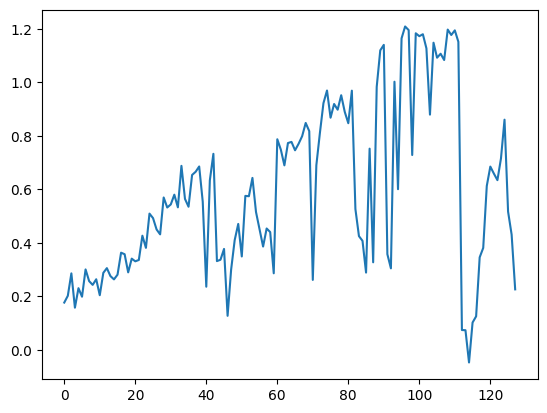

[PPO] Epoch 0: Loss=132.7838, Policy=0.0026, Value=265.6509
[PPO] Epoch 10: Loss=60.4066, Policy=0.0015, Value=120.9072
[PPO] Epoch 20: Loss=44.6705, Policy=-0.0011, Value=89.4399
[PPO] Epoch 30: Loss=31.9490, Policy=-0.0141, Value=64.0206
Approx KL Learned: 0.02324589714407921
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 33/100 — steps: 4096


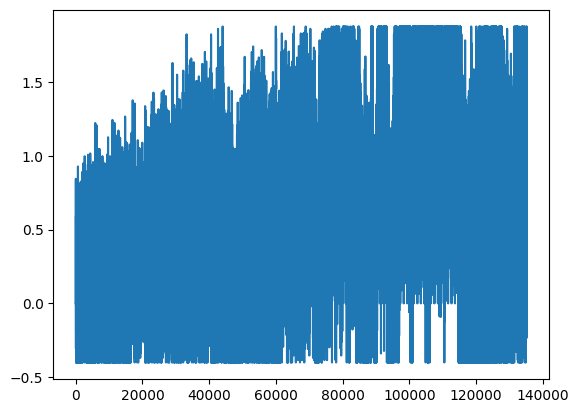

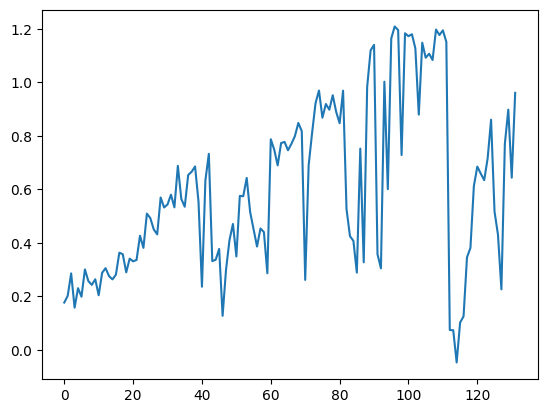

[PPO] Epoch 0: Loss=88.8486, Policy=0.0033, Value=177.8018
[PPO] Epoch 10: Loss=68.1913, Policy=-0.0025, Value=136.4967
[PPO] Epoch 20: Loss=58.9906, Policy=-0.0069, Value=118.1089
[PPO] Epoch 30: Loss=52.9283, Policy=-0.0134, Value=105.9958
Approx KL Learned: 0.016446003690361977
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 34/100 — steps: 4096


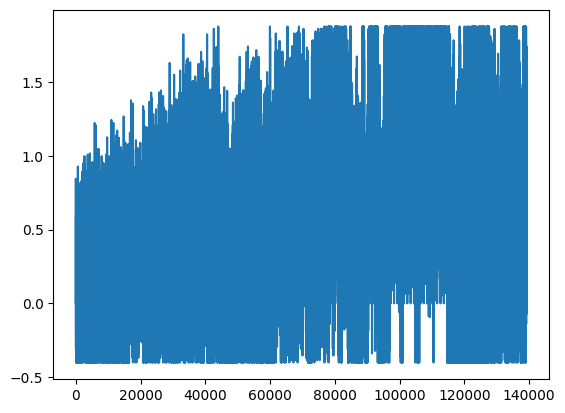

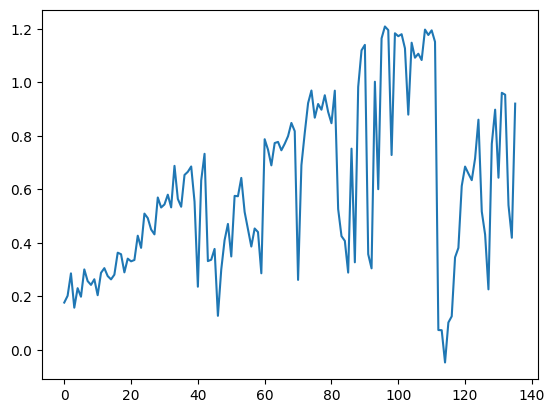

[PPO] Epoch 0: Loss=95.6882, Policy=0.0048, Value=191.4732
[PPO] Epoch 10: Loss=55.8595, Policy=-0.0012, Value=111.8261
[PPO] Epoch 20: Loss=41.7913, Policy=-0.0087, Value=83.7051
[PPO] Epoch 30: Loss=35.0189, Policy=-0.0192, Value=70.1816
Approx KL Learned: 0.017399676144123077
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 35/100 — steps: 4096


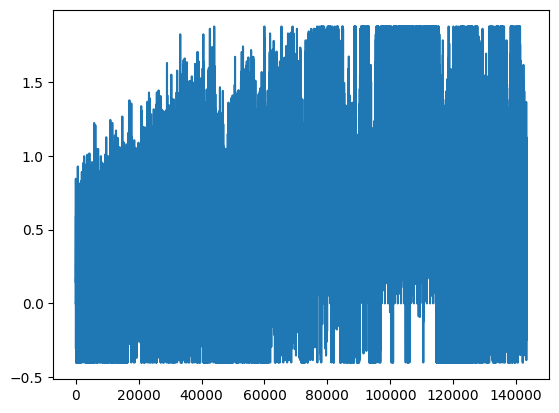

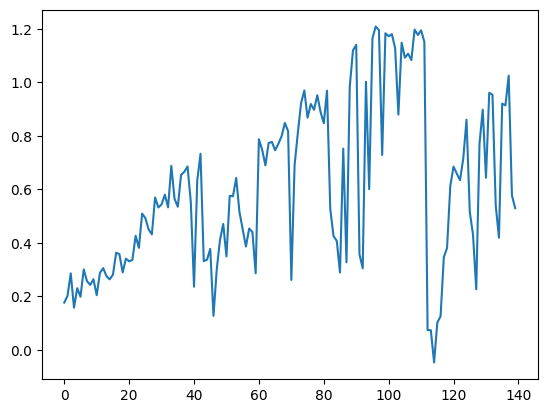

[PPO] Epoch 0: Loss=76.9737, Policy=0.0010, Value=154.0799
[PPO] Epoch 10: Loss=55.3388, Policy=-0.0005, Value=110.8134
[PPO] Epoch 20: Loss=54.3708, Policy=-0.0116, Value=108.8981
[PPO] Epoch 30: Loss=38.3528, Policy=-0.0128, Value=76.8677
Approx KL Learned: 0.01907820627093315
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 36/100 — steps: 4096


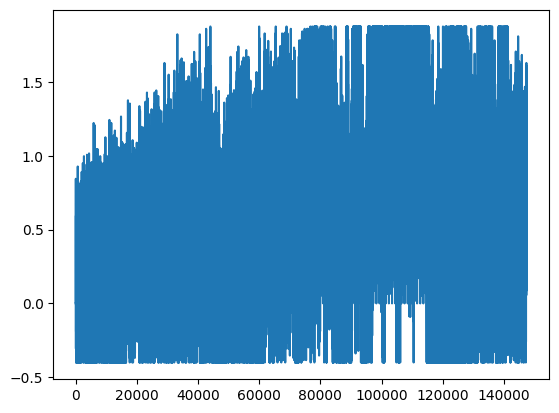

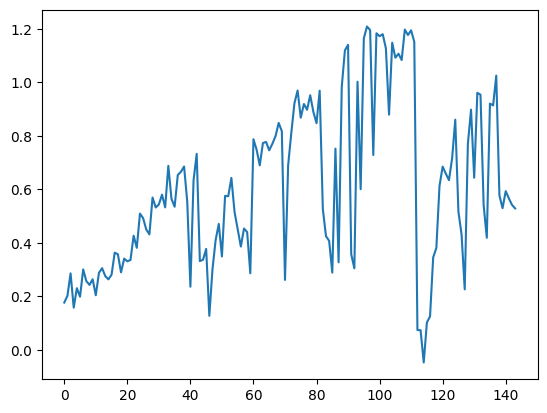

[PPO] Epoch 0: Loss=78.9923, Policy=0.0002, Value=158.1049
[PPO] Epoch 10: Loss=55.8821, Policy=-0.0030, Value=111.8924
[PPO] Epoch 20: Loss=46.9568, Policy=-0.0045, Value=94.0462
[PPO] Epoch 30: Loss=40.5923, Policy=-0.0102, Value=81.3282
Approx KL Learned: 0.022813037037849426
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 37/100 — steps: 4096


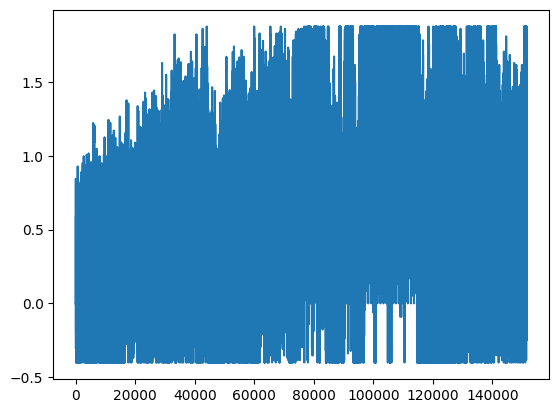

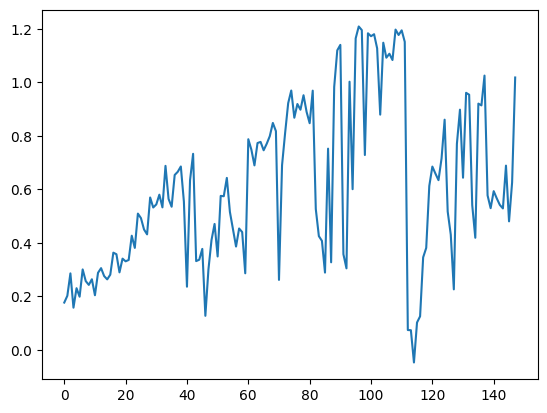

[PPO] Epoch 0: Loss=76.3768, Policy=0.0047, Value=152.8319
[PPO] Epoch 10: Loss=56.7315, Policy=0.0011, Value=113.5508
[PPO] Epoch 20: Loss=49.4420, Policy=-0.0122, Value=99.0026
[PPO] Epoch 30: Loss=44.0500, Policy=-0.0223, Value=88.2345
Approx KL Learned: 0.05834263563156128
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 38/100 — steps: 4096


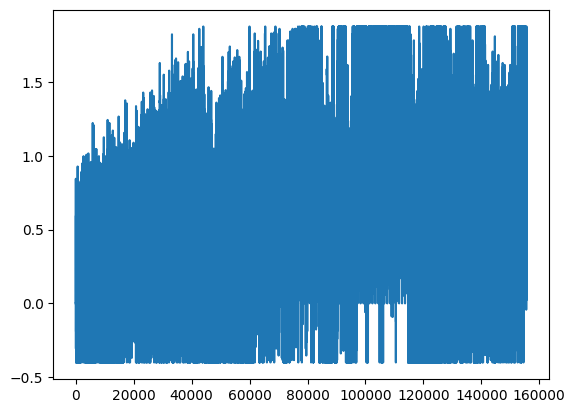

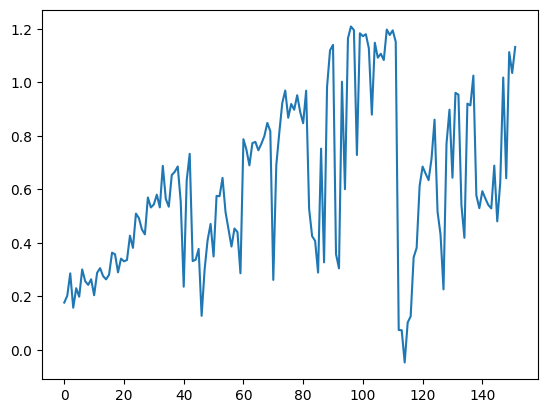

[PPO] Epoch 0: Loss=61.0657, Policy=0.0032, Value=122.2298
[PPO] Epoch 10: Loss=38.4930, Policy=-0.0013, Value=77.0923
[PPO] Epoch 20: Loss=32.3923, Policy=-0.0098, Value=64.9068
[PPO] Epoch 30: Loss=26.6972, Policy=-0.0204, Value=53.5393
Approx KL Learned: 0.03131735697388649
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 39/100 — steps: 4096


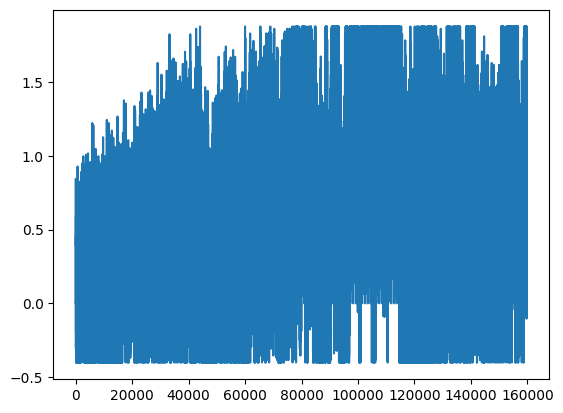

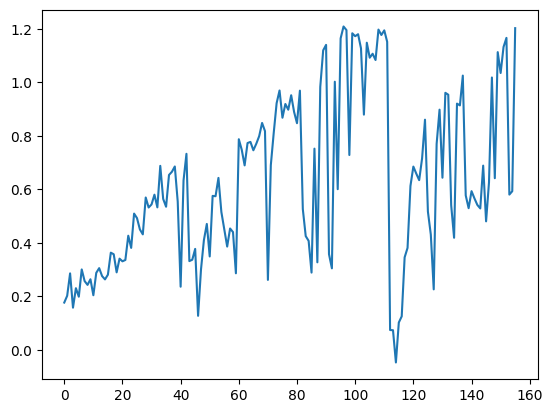

[PPO] Epoch 0: Loss=81.0799, Policy=0.0004, Value=162.2669
[PPO] Epoch 10: Loss=57.5358, Policy=-0.0061, Value=115.1910
[PPO] Epoch 20: Loss=48.8468, Policy=-0.0113, Value=97.8230
[PPO] Epoch 30: Loss=42.7858, Policy=-0.0234, Value=85.7222
Approx KL Learned: 0.029399123042821884
[✅] Actor-Critic checkpoint saved to chkpoint_39.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 40/100 — steps: 4096


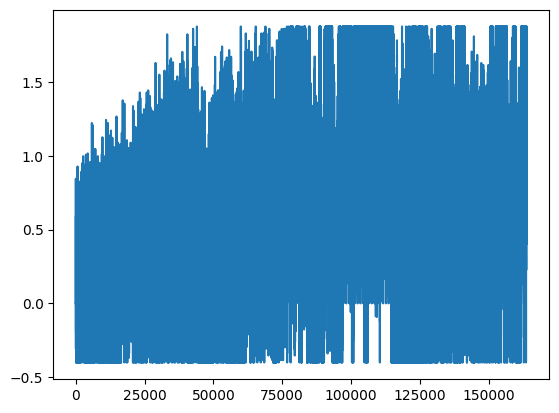

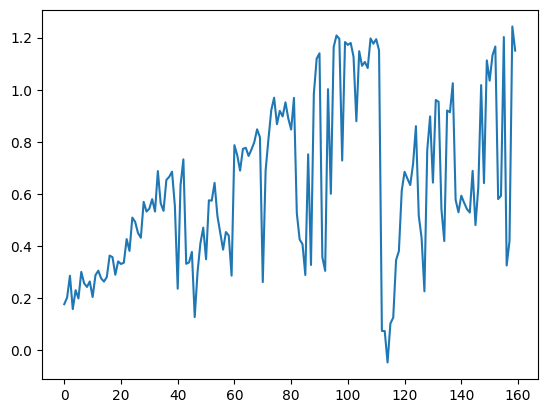

[PPO] Epoch 0: Loss=75.5072, Policy=0.0027, Value=151.0623
[PPO] Epoch 10: Loss=105.2597, Policy=-0.0035, Value=210.5901
[PPO] Epoch 20: Loss=22.5421, Policy=-0.0120, Value=45.1709
[PPO] Epoch 30: Loss=14.9292, Policy=-0.0173, Value=29.9603
Approx KL Learned: 0.048479318618774414
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 41/100 — steps: 4096


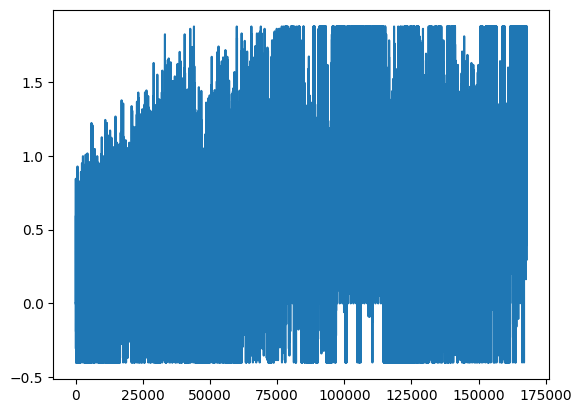

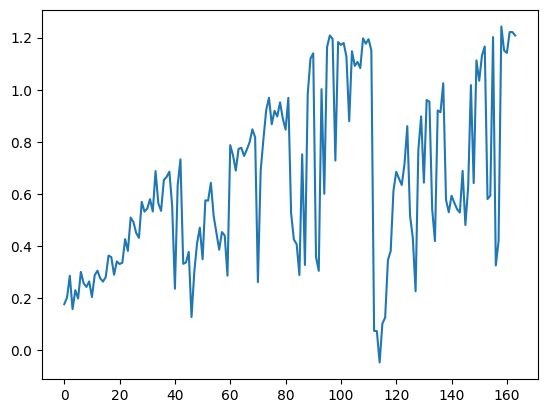

[PPO] Epoch 0: Loss=80.9061, Policy=0.0030, Value=161.8943
[PPO] Epoch 10: Loss=58.4059, Policy=-0.0054, Value=116.9085
[PPO] Epoch 20: Loss=48.1425, Policy=-0.0184, Value=96.4094
[PPO] Epoch 30: Loss=41.6426, Policy=-0.0235, Value=83.4208
Approx KL Learned: 0.026774341240525246
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 42/100 — steps: 4096


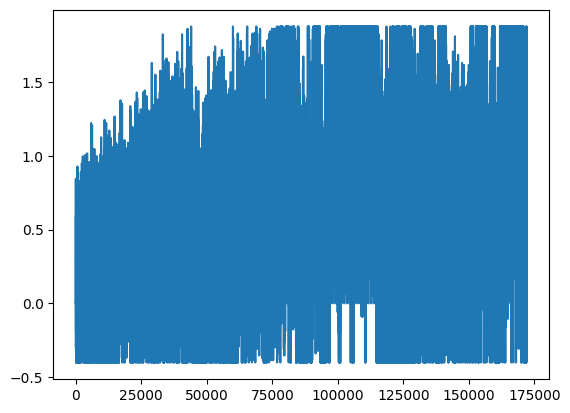

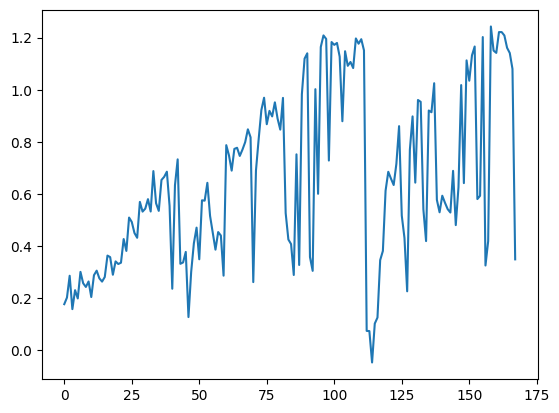

[PPO] Epoch 0: Loss=83.9518, Policy=0.0045, Value=167.9862
[PPO] Epoch 10: Loss=42.0246, Policy=-0.0027, Value=84.1446
[PPO] Epoch 20: Loss=34.9606, Policy=-0.0163, Value=70.0463
[PPO] Epoch 30: Loss=29.9557, Policy=-0.0265, Value=60.0594
Approx KL Learned: 0.03287418931722641
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 43/100 — steps: 4096


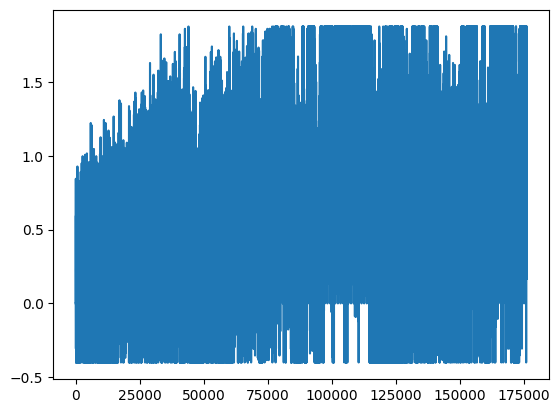

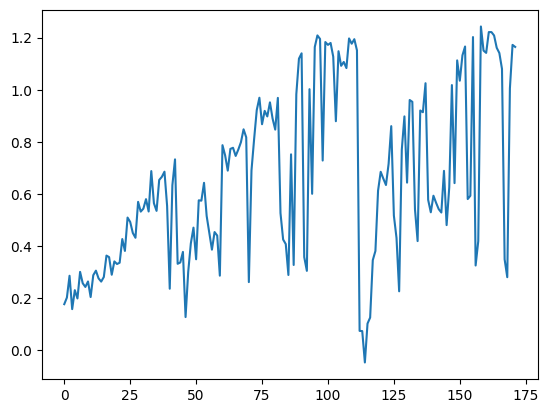

[PPO] Epoch 0: Loss=44.7105, Policy=0.0069, Value=89.4638
[PPO] Epoch 10: Loss=10.3244, Policy=-0.0012, Value=20.7029
[PPO] Epoch 20: Loss=7.8347, Policy=-0.0100, Value=15.7463
[PPO] Epoch 30: Loss=6.9710, Policy=-0.0154, Value=14.0326
Approx KL Learned: 0.05248075723648071
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 44/100 — steps: 4096


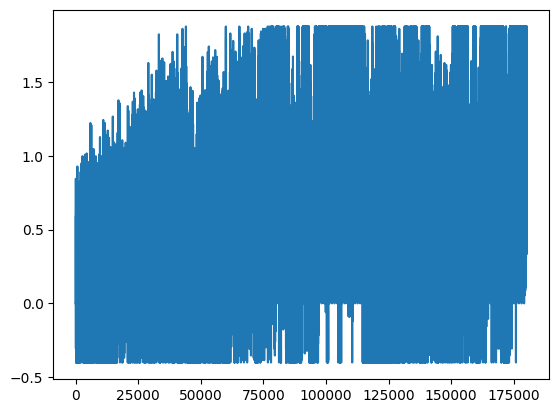

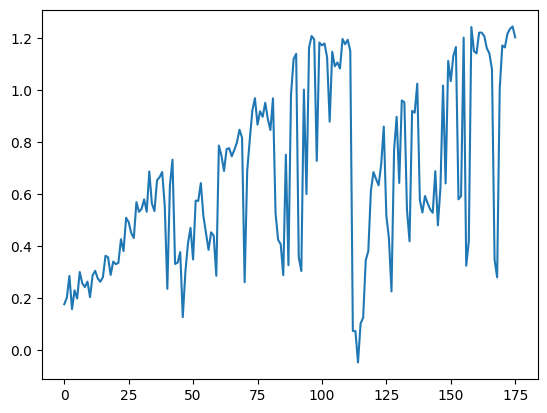

[PPO] Epoch 0: Loss=32.4496, Policy=0.0069, Value=64.9368
[PPO] Epoch 10: Loss=13.2866, Policy=0.0224, Value=26.5750
[PPO] Epoch 20: Loss=8.1171, Policy=0.0047, Value=16.2794
[PPO] Epoch 30: Loss=7.2061, Policy=-0.0039, Value=14.4700
Approx KL Learned: 0.025606391951441765
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 45/100 — steps: 4096


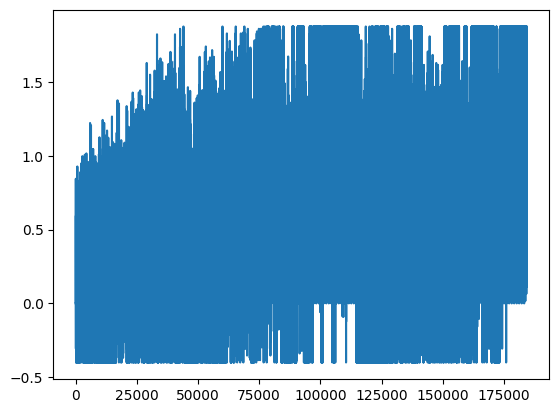

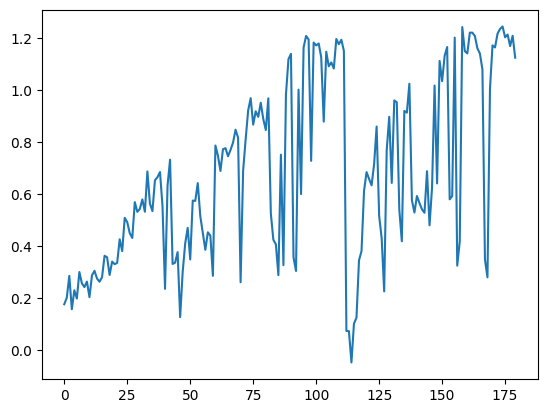

[PPO] Epoch 0: Loss=78.1822, Policy=0.0040, Value=156.4301
[PPO] Epoch 10: Loss=41.9494, Policy=0.0090, Value=83.9601
[PPO] Epoch 20: Loss=37.1673, Policy=-0.0046, Value=74.4212
[PPO] Epoch 30: Loss=34.2697, Policy=-0.0119, Value=68.6403
Approx KL Learned: 0.030015476047992706
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 46/100 — steps: 4096


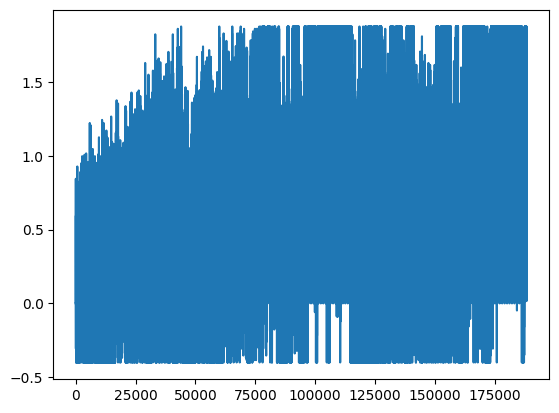

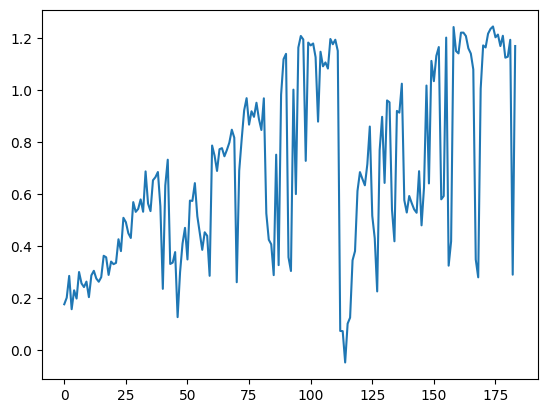

[PPO] Epoch 0: Loss=131.3814, Policy=0.0083, Value=262.8809
[PPO] Epoch 10: Loss=75.3209, Policy=0.0037, Value=150.7689
[PPO] Epoch 20: Loss=56.8474, Policy=-0.0008, Value=113.8298
[PPO] Epoch 30: Loss=46.9348, Policy=-0.0074, Value=94.0215
Approx KL Learned: 0.0216839462518692
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 47/100 — steps: 4096


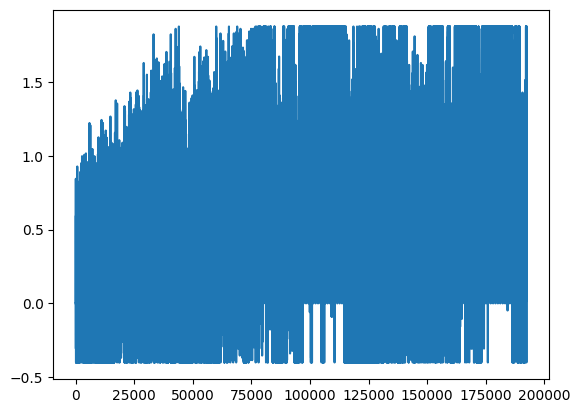

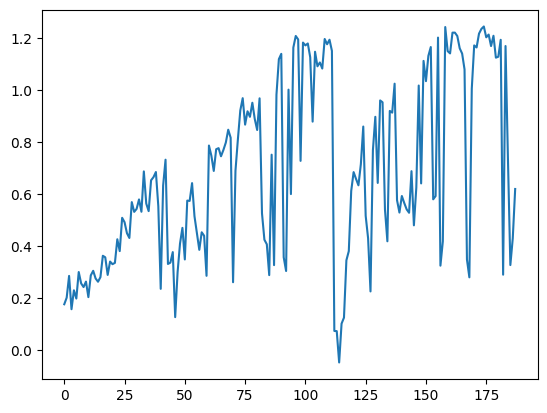

[PPO] Epoch 0: Loss=66.8294, Policy=0.0024, Value=133.7530
[PPO] Epoch 10: Loss=45.2724, Policy=-0.0011, Value=90.6491
[PPO] Epoch 20: Loss=37.8453, Policy=-0.0090, Value=75.8105
[PPO] Epoch 30: Loss=32.6565, Policy=-0.0131, Value=65.4397
Approx KL Learned: 0.02521810308098793
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 48/100 — steps: 4096


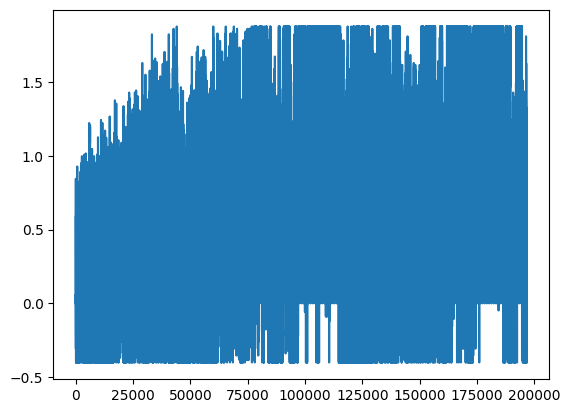

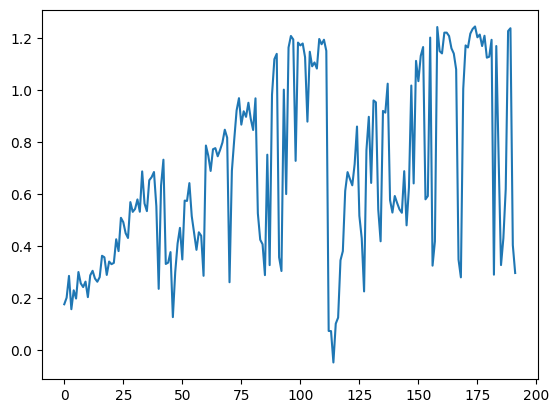

[PPO] Epoch 0: Loss=76.0543, Policy=0.0016, Value=152.1480
[PPO] Epoch 10: Loss=70.0707, Policy=-0.0024, Value=140.1942
[PPO] Epoch 20: Loss=13.6946, Policy=-0.0040, Value=27.4457
[PPO] Epoch 30: Loss=10.3136, Policy=-0.0120, Value=20.7028
Approx KL Learned: 0.0475529283285141
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 49/100 — steps: 4096


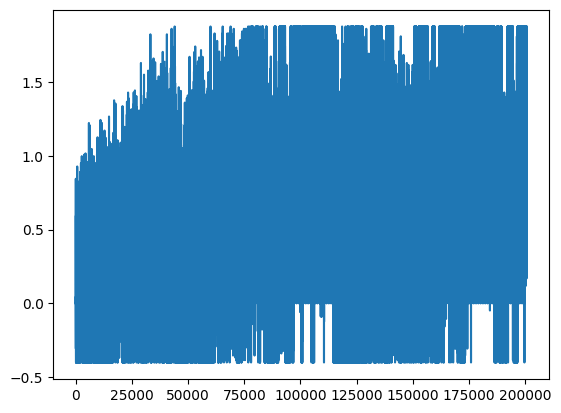

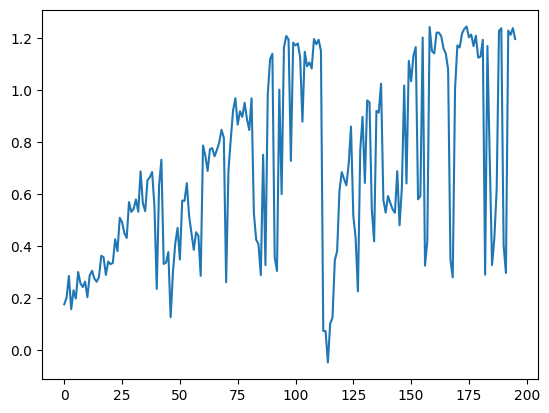

[PPO] Epoch 0: Loss=102.4549, Policy=0.0011, Value=205.0423
[PPO] Epoch 10: Loss=52.7808, Policy=-0.0052, Value=105.7049
[PPO] Epoch 20: Loss=42.9133, Policy=-0.0145, Value=85.9884
[PPO] Epoch 30: Loss=35.9884, Policy=-0.0181, Value=72.1466
Approx KL Learned: 0.024501528590917587
[✅] Actor-Critic checkpoint saved to chkpoint_49.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 50/100 — steps: 4096


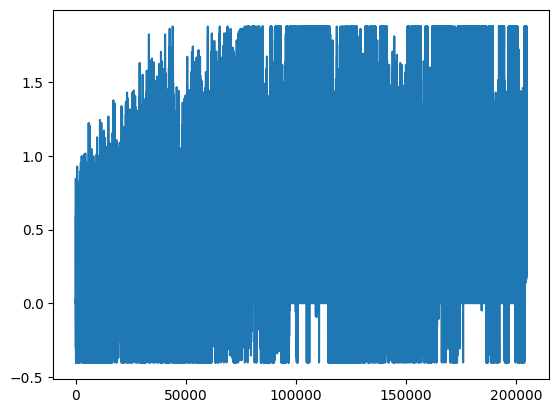

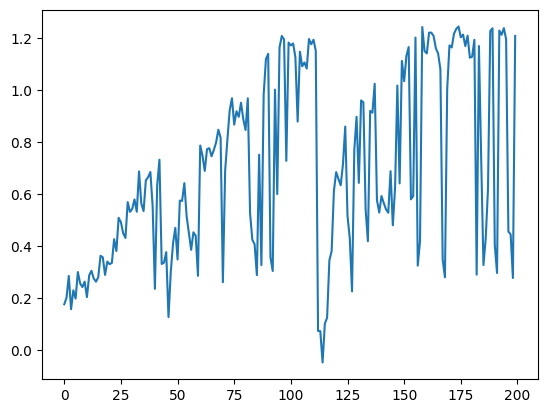

[PPO] Epoch 0: Loss=64.7041, Policy=0.0027, Value=129.4796
[PPO] Epoch 10: Loss=27.3863, Policy=-0.0024, Value=54.8564
[PPO] Epoch 20: Loss=22.4617, Policy=-0.0126, Value=45.0283
[PPO] Epoch 30: Loss=18.6217, Policy=-0.0220, Value=37.3677
Approx KL Learned: 0.04398414120078087
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 51/100 — steps: 4096


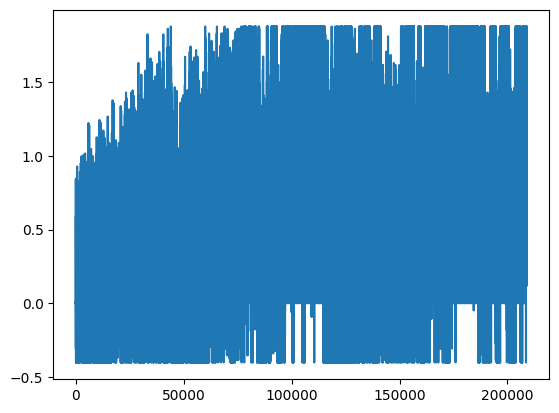

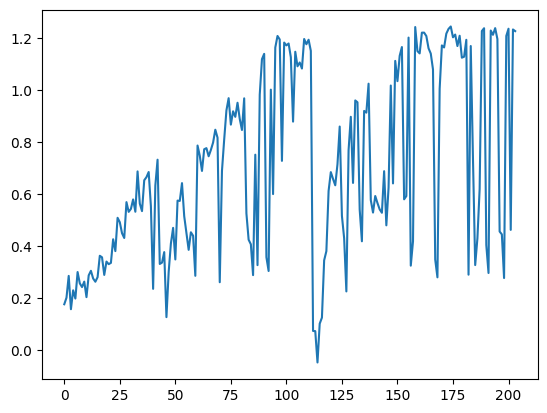

[PPO] Epoch 0: Loss=101.0547, Policy=0.0046, Value=202.1765
[PPO] Epoch 10: Loss=27.2725, Policy=0.0000, Value=54.6235
[PPO] Epoch 20: Loss=18.1287, Policy=-0.0063, Value=36.3469
[PPO] Epoch 30: Loss=14.4984, Policy=-0.0164, Value=29.1083
Approx KL Learned: 0.08308787643909454
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 52/100 — steps: 4096


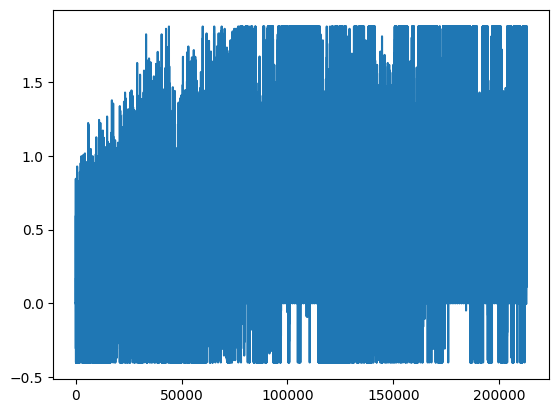

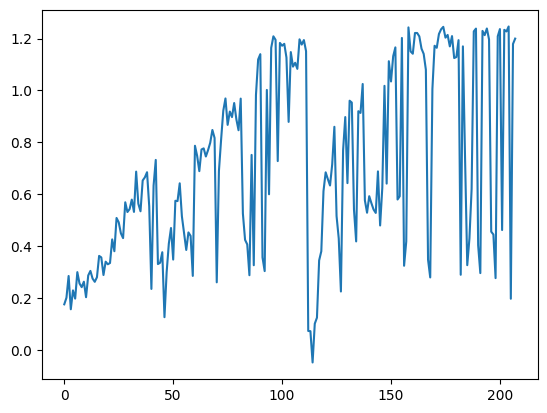

[PPO] Epoch 0: Loss=71.5116, Policy=0.0121, Value=143.0712
[PPO] Epoch 10: Loss=22.7400, Policy=-0.0010, Value=45.5448
[PPO] Epoch 20: Loss=21.2184, Policy=-0.0087, Value=42.5182
[PPO] Epoch 30: Loss=16.3807, Policy=-0.0144, Value=32.8578
Approx KL Learned: 0.02091819792985916
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 53/100 — steps: 4096


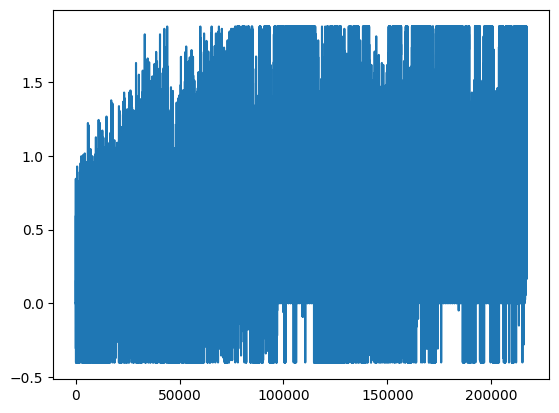

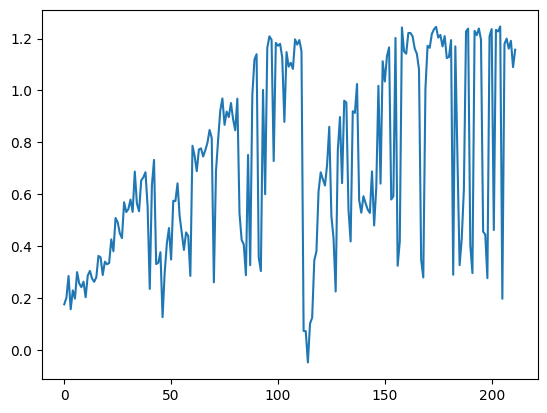

[PPO] Epoch 0: Loss=78.0523, Policy=0.0046, Value=156.2108
[PPO] Epoch 10: Loss=38.7622, Policy=-0.0052, Value=77.6442
[PPO] Epoch 20: Loss=32.4567, Policy=-0.0102, Value=65.0482
[PPO] Epoch 30: Loss=27.3698, Policy=-0.0178, Value=54.8880
Approx KL Learned: 0.02040739171206951
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 54/100 — steps: 4096


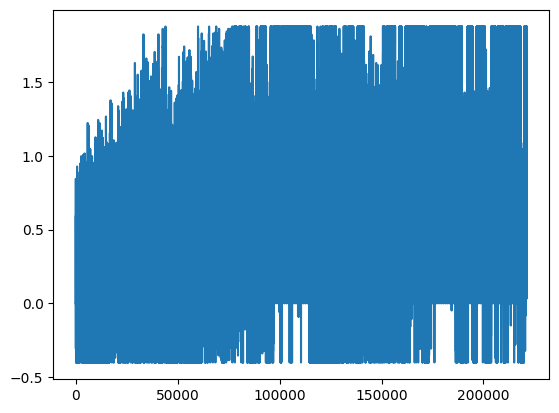

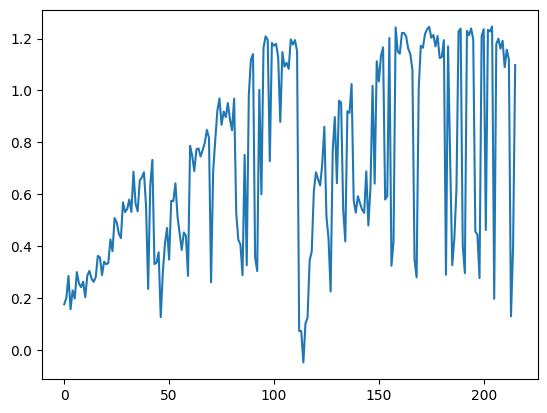

[PPO] Epoch 0: Loss=95.3646, Policy=0.0033, Value=190.8563
[PPO] Epoch 10: Loss=59.1977, Policy=-0.0033, Value=118.5344
[PPO] Epoch 20: Loss=46.3657, Policy=-0.0120, Value=92.8864
[PPO] Epoch 30: Loss=39.6072, Policy=-0.0114, Value=79.3676
Approx KL Learned: 0.023458968847990036
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 55/100 — steps: 4096


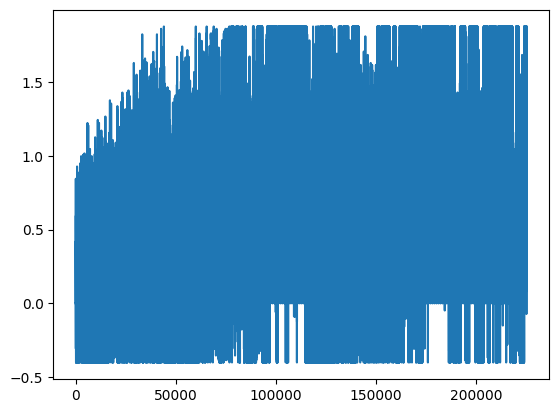

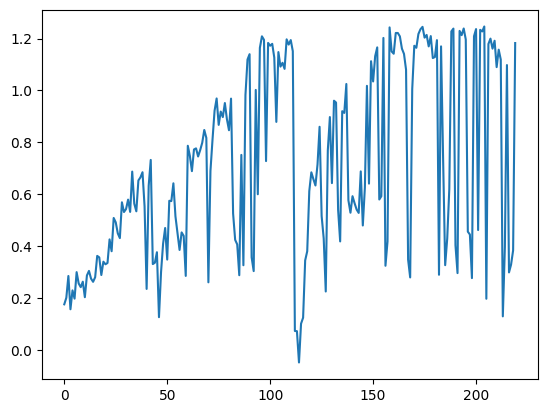

[PPO] Epoch 0: Loss=89.8859, Policy=0.0040, Value=179.8159
[PPO] Epoch 10: Loss=63.5096, Policy=-0.0019, Value=127.0794
[PPO] Epoch 20: Loss=18.9443, Policy=-0.0084, Value=37.9659
[PPO] Epoch 30: Loss=12.2055, Policy=-0.0159, Value=24.5032
Approx KL Learned: 0.04702197387814522
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 56/100 — steps: 4096


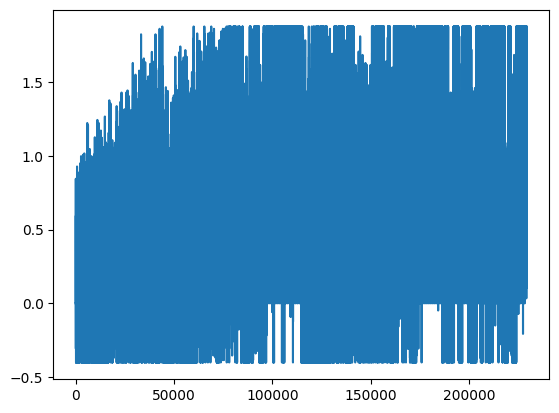

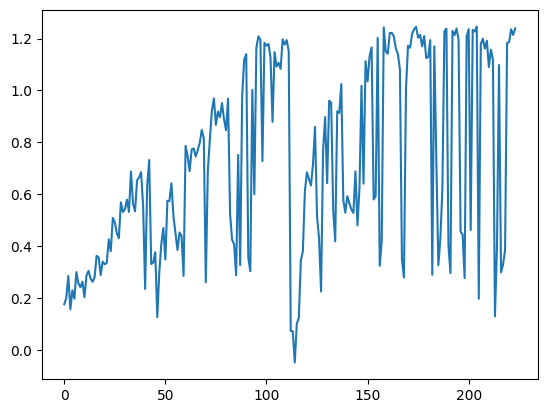

[PPO] Epoch 0: Loss=109.5191, Policy=0.0041, Value=219.1145
[PPO] Epoch 10: Loss=56.8079, Policy=0.0022, Value=113.6915
[PPO] Epoch 20: Loss=39.2144, Policy=-0.0051, Value=78.5204
[PPO] Epoch 30: Loss=26.8476, Policy=-0.0004, Value=53.7762
Approx KL Learned: 0.2561473548412323
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 57/100 — steps: 4096


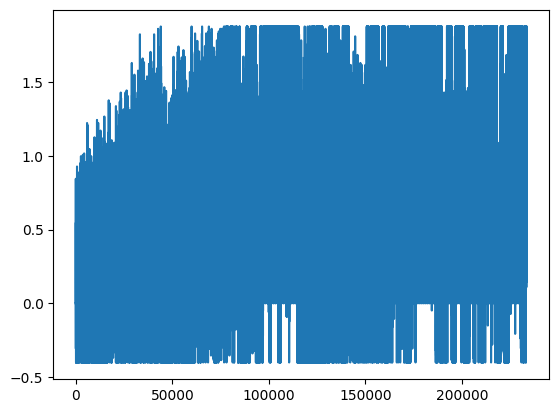

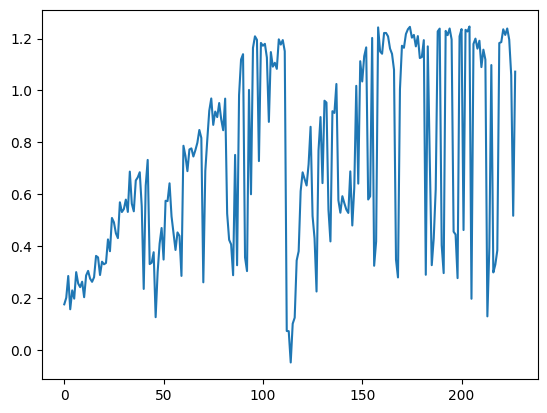

[PPO] Epoch 0: Loss=65.1016, Policy=0.0007, Value=130.2445
[PPO] Epoch 10: Loss=26.2838, Policy=0.0023, Value=52.6152
[PPO] Epoch 20: Loss=17.2496, Policy=-0.0061, Value=34.5609
[PPO] Epoch 30: Loss=12.6426, Policy=-0.0097, Value=25.3562
Approx KL Learned: 0.11800876259803772
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 58/100 — steps: 4096


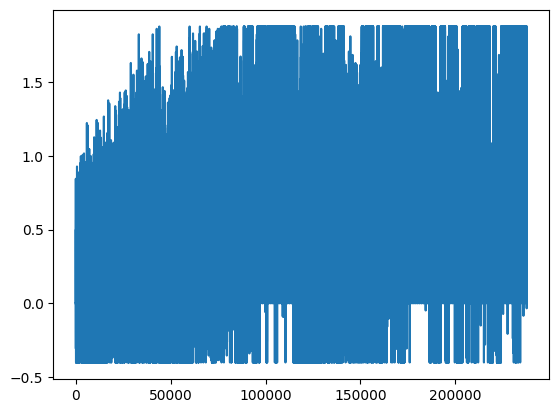

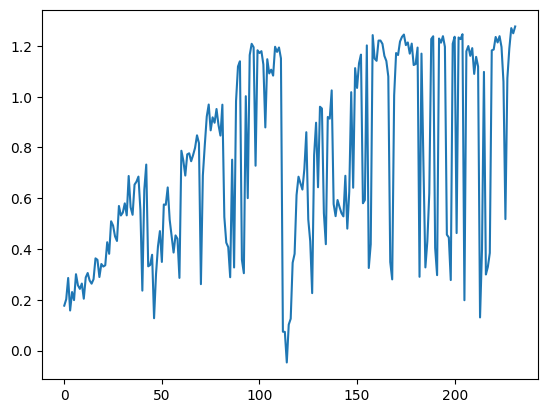

[PPO] Epoch 0: Loss=63.2456, Policy=0.0018, Value=126.5723
[PPO] Epoch 10: Loss=45.9832, Policy=-0.0018, Value=92.0451
[PPO] Epoch 20: Loss=38.5215, Policy=-0.0122, Value=77.1511
[PPO] Epoch 30: Loss=32.6821, Policy=-0.0164, Value=65.4806
Approx KL Learned: 0.02691790461540222
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 59/100 — steps: 4096


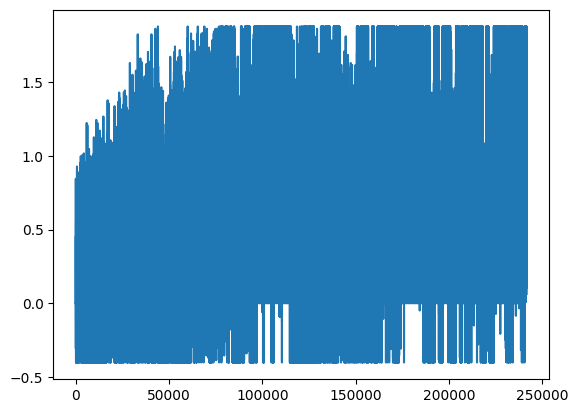

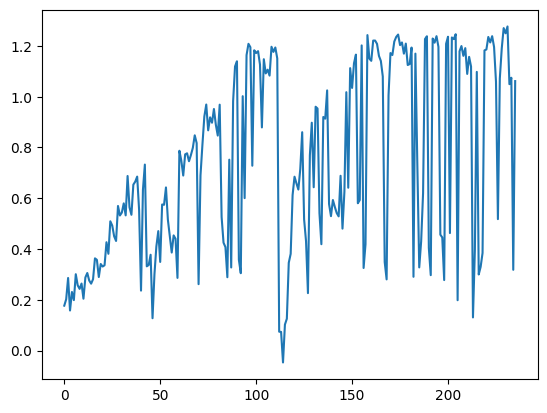

[PPO] Epoch 0: Loss=53.1403, Policy=0.0066, Value=106.3306
[PPO] Epoch 10: Loss=27.8560, Policy=-0.0047, Value=55.7746
[PPO] Epoch 20: Loss=18.8370, Policy=-0.0085, Value=37.7476
[PPO] Epoch 30: Loss=13.4494, Policy=-0.0141, Value=26.9805
Approx KL Learned: 0.041309893131256104
[✅] Actor-Critic checkpoint saved to chkpoint_59.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 60/100 — steps: 4096


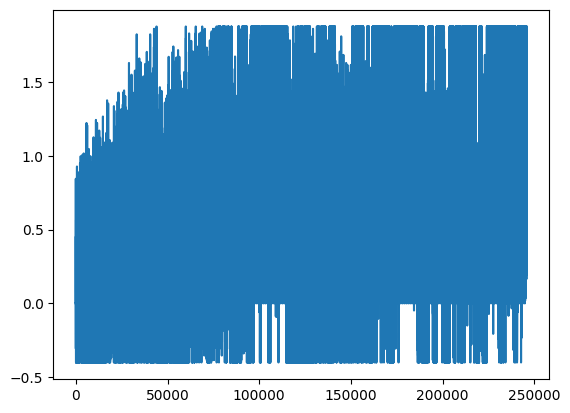

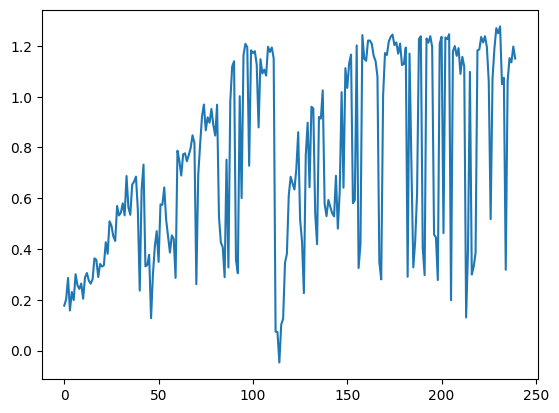

[PPO] Epoch 0: Loss=105.4783, Policy=0.0036, Value=211.0482
[PPO] Epoch 10: Loss=30.2464, Policy=-0.0017, Value=60.5951
[PPO] Epoch 20: Loss=26.2591, Policy=-0.0068, Value=52.6358
[PPO] Epoch 30: Loss=21.7142, Policy=-0.0164, Value=43.5630
Approx KL Learned: 0.04284486174583435
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 61/100 — steps: 4096


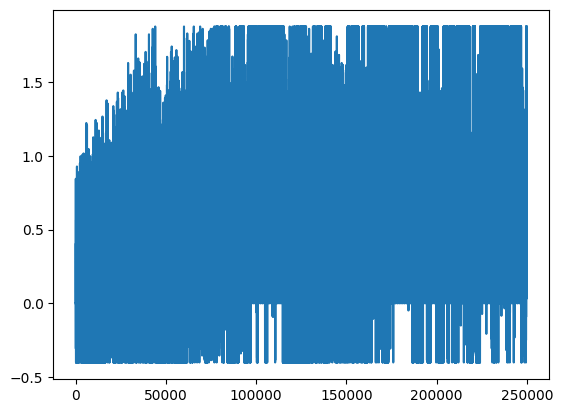

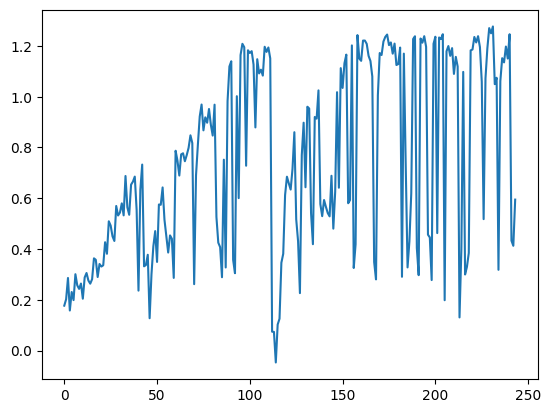

[PPO] Epoch 0: Loss=54.4245, Policy=0.0016, Value=108.9235
[PPO] Epoch 10: Loss=31.2279, Policy=-0.0034, Value=62.5408
[PPO] Epoch 20: Loss=22.2666, Policy=-0.0136, Value=44.6411
[PPO] Epoch 30: Loss=18.5118, Policy=-0.0248, Value=37.1530
Approx KL Learned: 0.06201551854610443
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 62/100 — steps: 4096


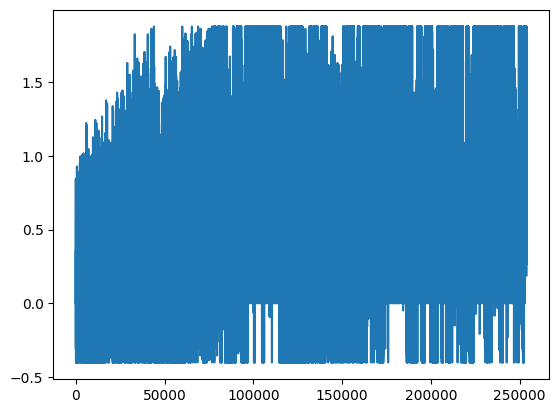

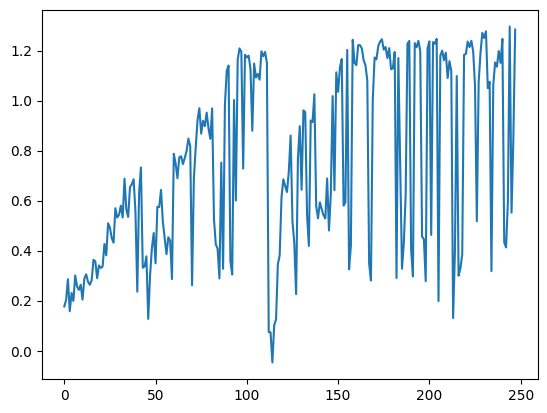

[PPO] Epoch 0: Loss=114.1225, Policy=0.0047, Value=228.2809
[PPO] Epoch 10: Loss=49.4821, Policy=0.0027, Value=99.0090
[PPO] Epoch 20: Loss=26.5561, Policy=-0.0083, Value=53.1839
[PPO] Epoch 30: Loss=15.4854, Policy=-0.0139, Value=31.0545
Approx KL Learned: 0.036071356385946274
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 63/100 — steps: 4096


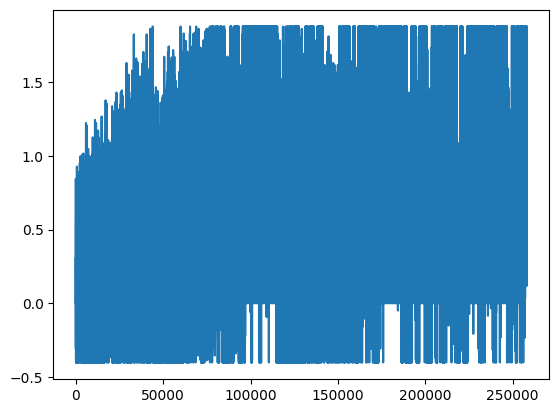

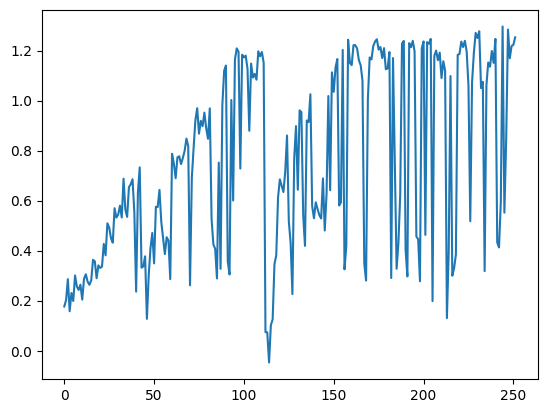

[PPO] Epoch 0: Loss=74.0775, Policy=0.0054, Value=148.2471
[PPO] Epoch 10: Loss=32.3873, Policy=0.0005, Value=64.8798
[PPO] Epoch 20: Loss=23.3055, Policy=-0.0165, Value=46.7461
[PPO] Epoch 30: Loss=16.4964, Policy=-0.0080, Value=33.1145
Approx KL Learned: 0.06727533042430878
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 64/100 — steps: 4096


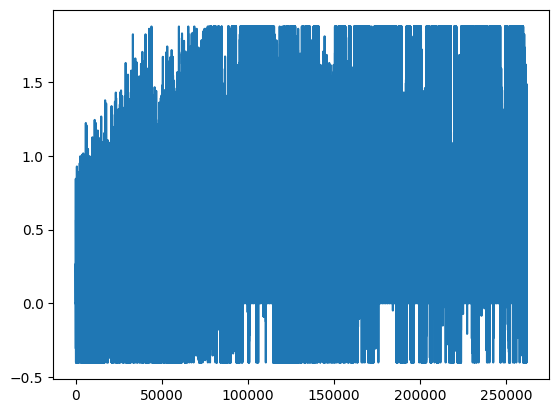

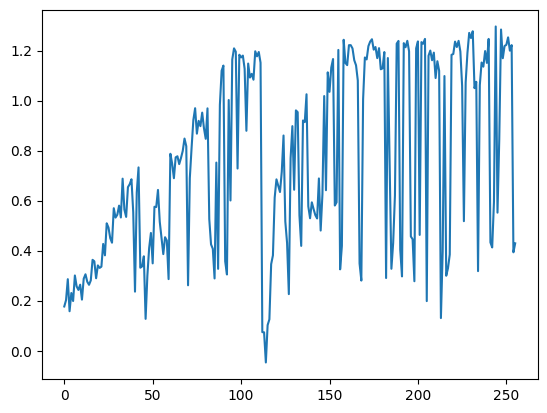

[PPO] Epoch 0: Loss=100.3015, Policy=0.0024, Value=200.7093
[PPO] Epoch 10: Loss=56.3265, Policy=0.0038, Value=112.7519
[PPO] Epoch 20: Loss=43.1134, Policy=-0.0075, Value=86.3623
[PPO] Epoch 30: Loss=35.7135, Policy=-0.0168, Value=71.5768
Approx KL Learned: 0.025156274437904358
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 65/100 — steps: 4096


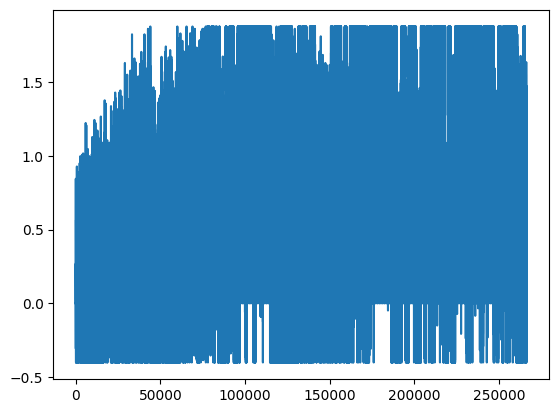

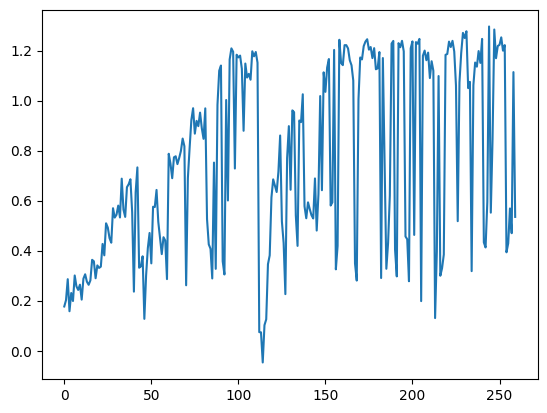

[PPO] Epoch 0: Loss=56.8327, Policy=-0.0008, Value=113.7483
[PPO] Epoch 10: Loss=39.7226, Policy=-0.0041, Value=79.5363
[PPO] Epoch 20: Loss=30.3970, Policy=-0.0128, Value=60.9010
[PPO] Epoch 30: Loss=26.6060, Policy=-0.0202, Value=53.3341
Approx KL Learned: 0.023173460736870766
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 66/100 — steps: 4096


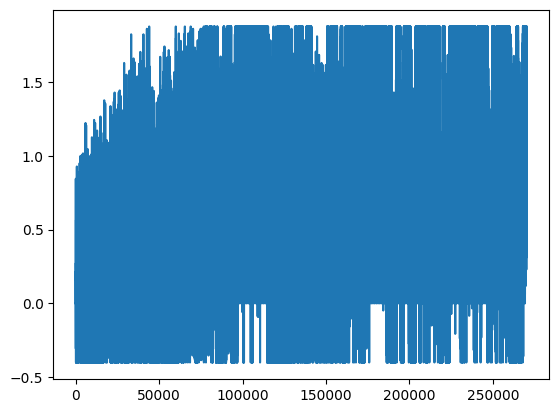

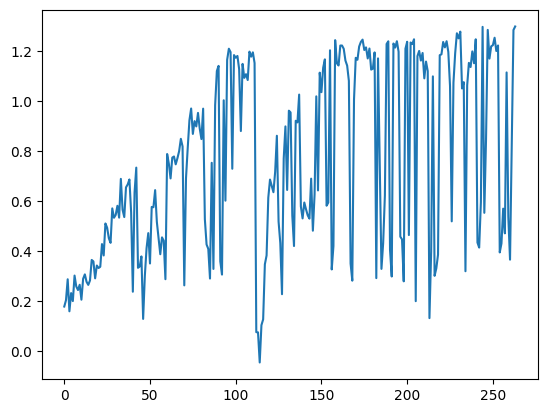

[PPO] Epoch 0: Loss=58.1853, Policy=0.0001, Value=116.4358
[PPO] Epoch 10: Loss=28.1931, Policy=-0.0015, Value=56.4565
[PPO] Epoch 20: Loss=21.4683, Policy=-0.0101, Value=43.0284
[PPO] Epoch 30: Loss=16.1579, Policy=-0.0193, Value=32.4279
Approx KL Learned: 0.04141906648874283
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 67/100 — steps: 4096


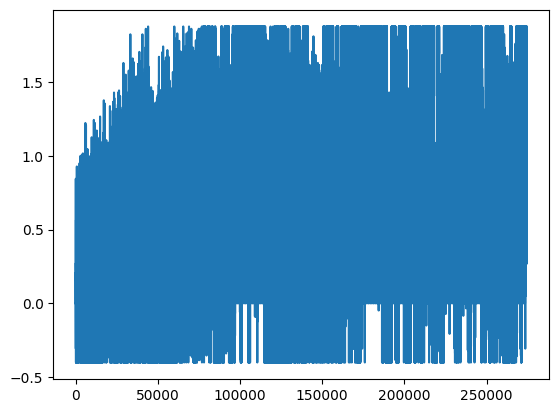

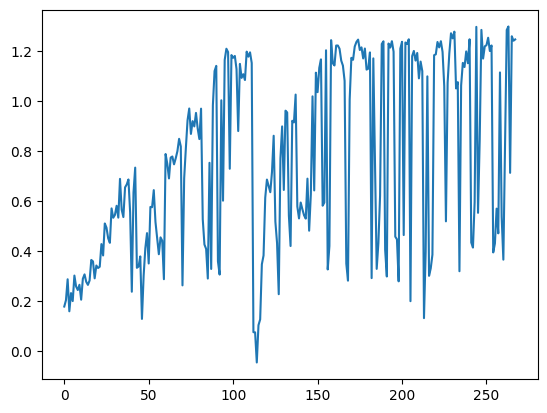

[PPO] Epoch 0: Loss=70.1741, Policy=0.0002, Value=140.4241
[PPO] Epoch 10: Loss=35.4001, Policy=-0.0050, Value=70.8862
[PPO] Epoch 20: Loss=22.3477, Policy=-0.0125, Value=44.7977
[PPO] Epoch 30: Loss=17.4482, Policy=-0.0180, Value=35.0109
Approx KL Learned: 0.02698316052556038
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 68/100 — steps: 4096


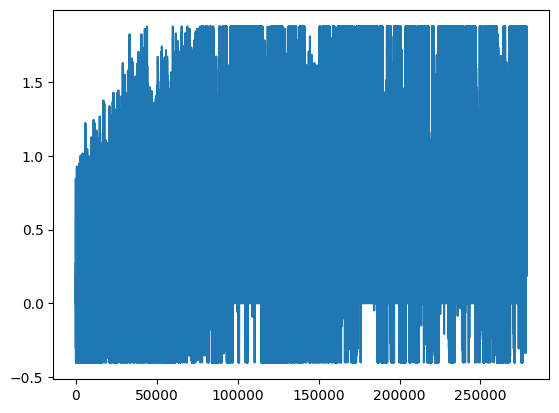

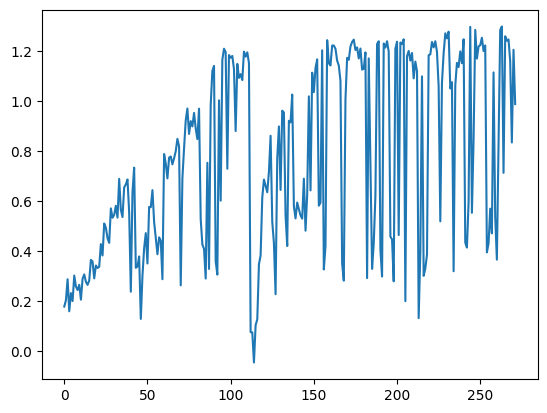

[PPO] Epoch 0: Loss=58.5186, Policy=0.0040, Value=117.1086
[PPO] Epoch 10: Loss=42.1641, Policy=-0.0019, Value=84.4143
[PPO] Epoch 20: Loss=33.5340, Policy=-0.0111, Value=67.1729
[PPO] Epoch 30: Loss=25.3123, Policy=-0.0164, Value=50.7426
Approx KL Learned: 0.019376585260033607
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 69/100 — steps: 4096


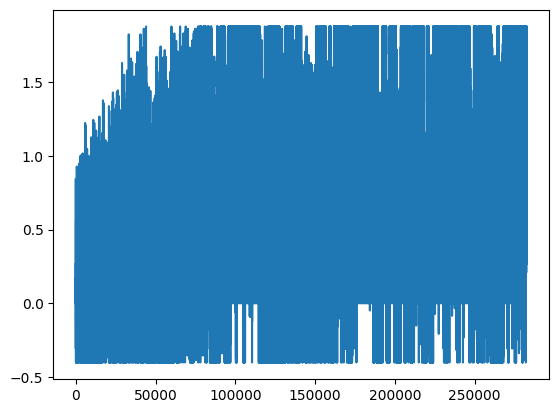

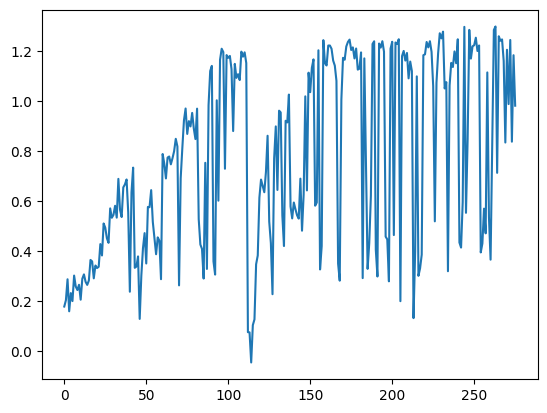

[PPO] Epoch 0: Loss=45.2167, Policy=0.0038, Value=90.4976
[PPO] Epoch 10: Loss=22.5371, Policy=-0.0074, Value=45.1557
[PPO] Epoch 20: Loss=16.3131, Policy=-0.0139, Value=32.7203
[PPO] Epoch 30: Loss=13.4416, Policy=-0.0254, Value=27.0048
Approx KL Learned: 0.026000745594501495
[✅] Actor-Critic checkpoint saved to chkpoint_69.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 70/100 — steps: 4096


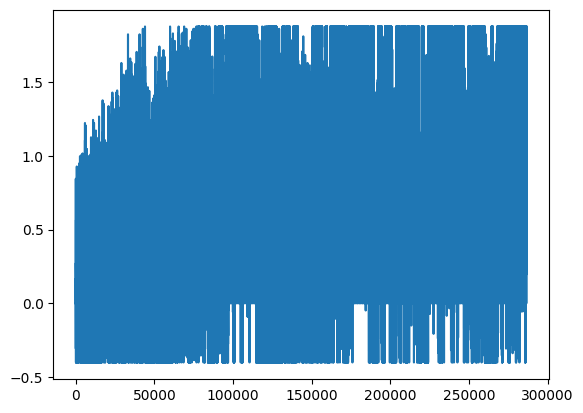

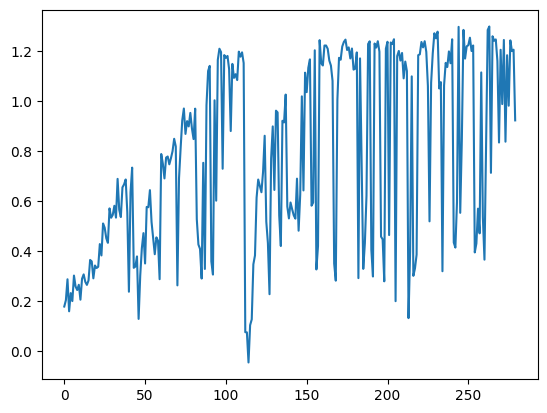

[PPO] Epoch 0: Loss=56.1162, Policy=0.0050, Value=112.2936
[PPO] Epoch 10: Loss=34.6193, Policy=-0.0030, Value=69.3116
[PPO] Epoch 20: Loss=25.5467, Policy=-0.0095, Value=51.1812
[PPO] Epoch 30: Loss=23.1041, Policy=-0.0175, Value=46.3112
Approx KL Learned: 0.02292838878929615
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 71/100 — steps: 4096


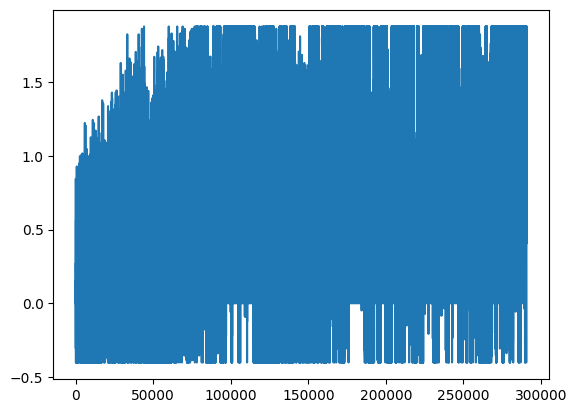

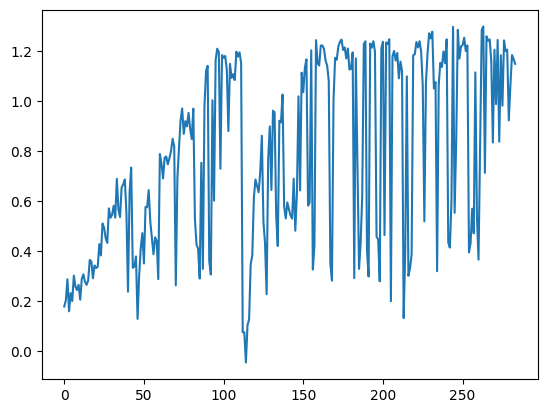

[PPO] Epoch 0: Loss=41.5911, Policy=0.0050, Value=83.2689
[PPO] Epoch 10: Loss=30.8515, Policy=-0.0074, Value=61.8128
[PPO] Epoch 20: Loss=24.3143, Policy=-0.0237, Value=48.7762
[PPO] Epoch 30: Loss=20.2215, Policy=-0.0347, Value=40.6169
Approx KL Learned: 0.056701093912124634
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 72/100 — steps: 4096


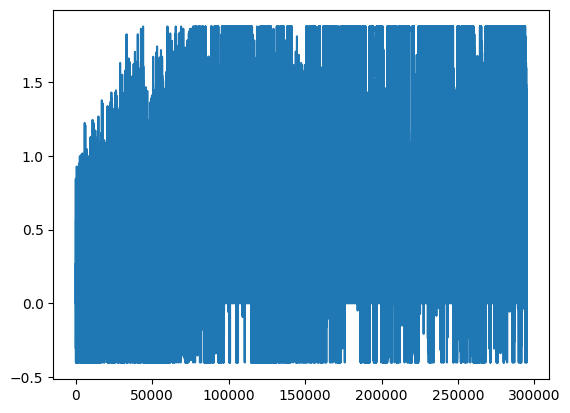

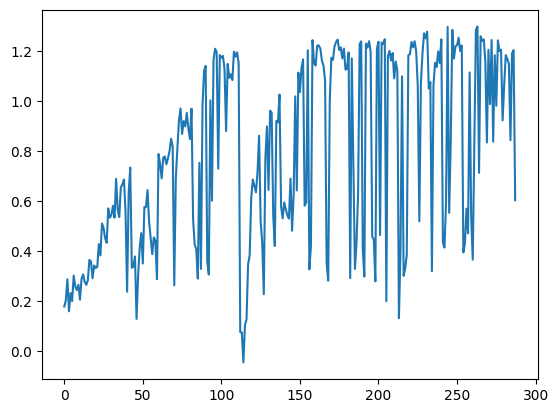

[PPO] Epoch 0: Loss=68.1069, Policy=0.0070, Value=136.3077
[PPO] Epoch 10: Loss=49.4363, Policy=-0.0030, Value=98.9868
[PPO] Epoch 20: Loss=38.8550, Policy=-0.0181, Value=77.8516
[PPO] Epoch 30: Loss=32.8794, Policy=-0.0266, Value=65.9179
Approx KL Learned: 0.025873200967907906
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 73/100 — steps: 4096


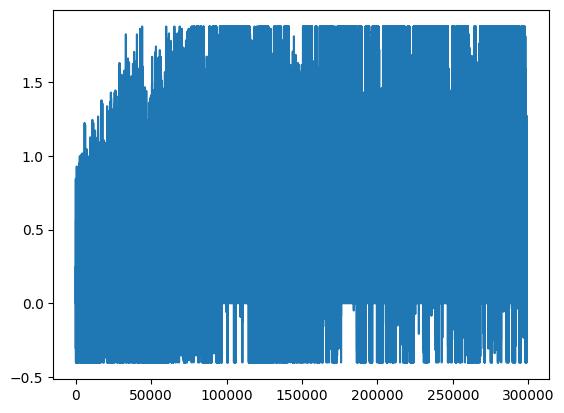

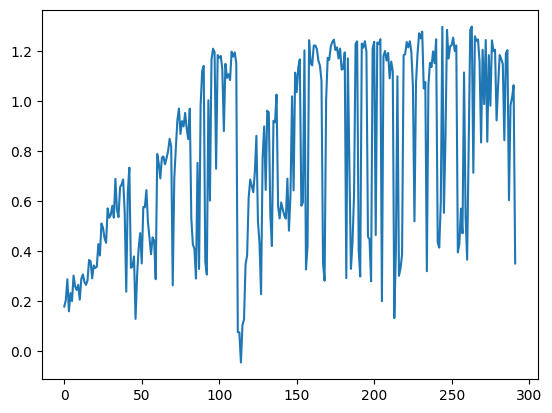

[PPO] Epoch 0: Loss=67.7575, Policy=0.0057, Value=135.6238
[PPO] Epoch 10: Loss=42.7794, Policy=-0.0085, Value=85.6934
[PPO] Epoch 20: Loss=34.1622, Policy=-0.0181, Value=68.4813
[PPO] Epoch 30: Loss=28.0294, Policy=-0.0301, Value=56.2395
Approx KL Learned: 0.03618061542510986
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 74/100 — steps: 4096


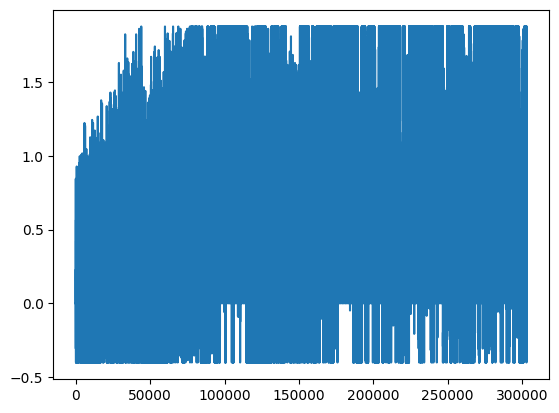

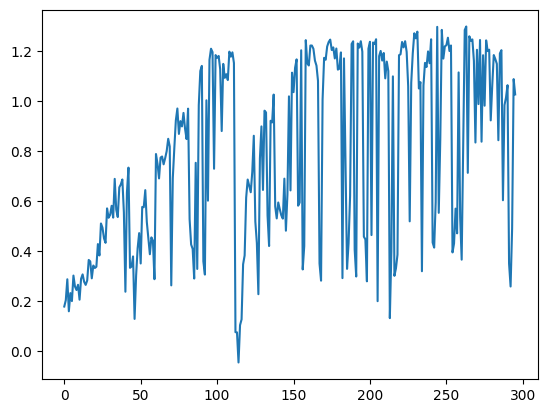

[PPO] Epoch 0: Loss=86.1996, Policy=0.0055, Value=172.4715
[PPO] Epoch 10: Loss=39.6583, Policy=-0.0045, Value=79.4008
[PPO] Epoch 20: Loss=21.7817, Policy=-0.0140, Value=43.6675
[PPO] Epoch 30: Loss=14.8068, Policy=-0.0235, Value=29.7396
Approx KL Learned: 0.04364306852221489
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 75/100 — steps: 4096


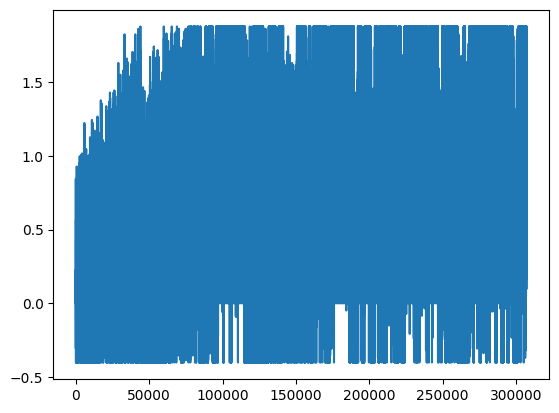

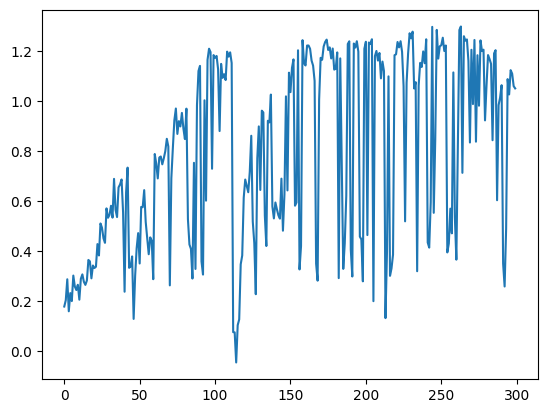

[PPO] Epoch 0: Loss=48.9623, Policy=0.0035, Value=97.9881
[PPO] Epoch 10: Loss=18.8510, Policy=0.0076, Value=37.7314
[PPO] Epoch 20: Loss=14.0991, Policy=0.0116, Value=28.2551
[PPO] Epoch 30: Loss=13.1628, Policy=-0.0040, Value=26.4044
Approx KL Learned: 0.07854585349559784
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 76/100 — steps: 4096


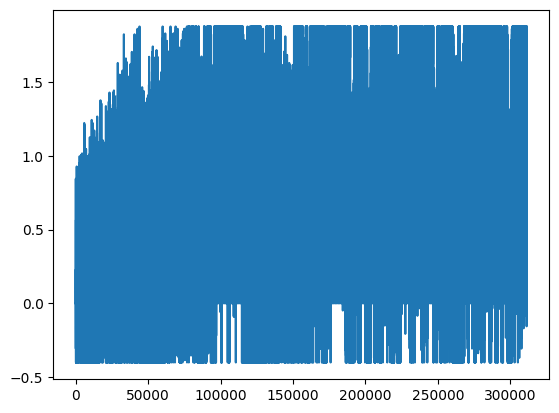

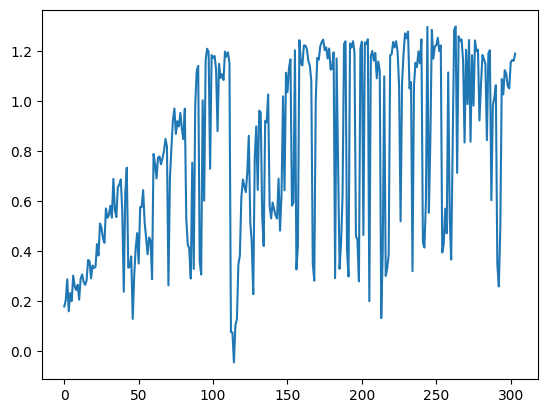

[PPO] Epoch 0: Loss=175.5078, Policy=0.0039, Value=351.0957
[PPO] Epoch 10: Loss=51.9143, Policy=0.0353, Value=103.8577
[PPO] Epoch 20: Loss=26.0345, Policy=0.0004, Value=52.1618
[PPO] Epoch 30: Loss=17.7889, Policy=-0.0111, Value=35.6886
Approx KL Learned: 0.01995256170630455
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 77/100 — steps: 4096


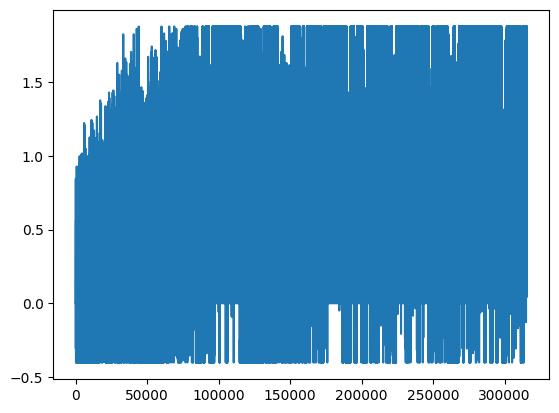

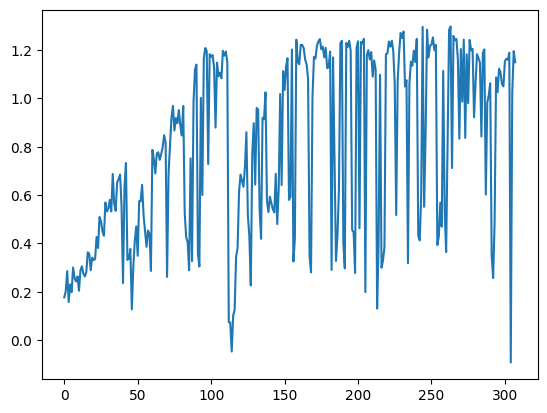

[PPO] Epoch 0: Loss=61.0516, Policy=0.0026, Value=122.1655
[PPO] Epoch 10: Loss=28.9552, Policy=-0.0027, Value=57.9842
[PPO] Epoch 20: Loss=16.5595, Policy=-0.0152, Value=33.2229
[PPO] Epoch 30: Loss=12.5323, Policy=-0.0235, Value=25.1832
Approx KL Learned: 0.033783964812755585
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 78/100 — steps: 4096


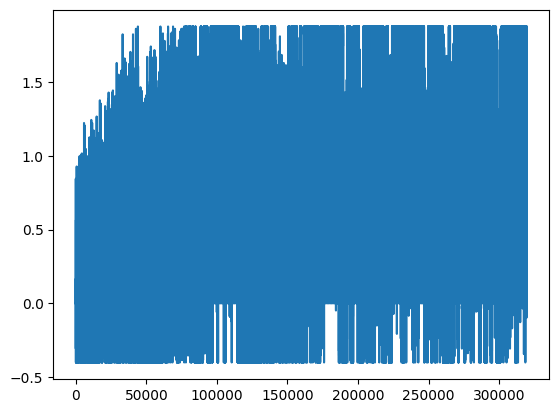

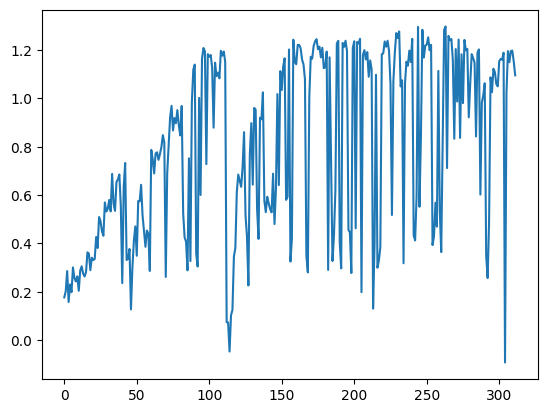

[PPO] Epoch 0: Loss=60.7440, Policy=0.0040, Value=121.5715
[PPO] Epoch 10: Loss=38.2301, Policy=-0.0084, Value=76.5676
[PPO] Epoch 20: Loss=26.6018, Policy=-0.0263, Value=53.3458
[PPO] Epoch 30: Loss=19.8995, Policy=-0.0392, Value=39.9674
Approx KL Learned: 0.039857350289821625
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 79/100 — steps: 4096


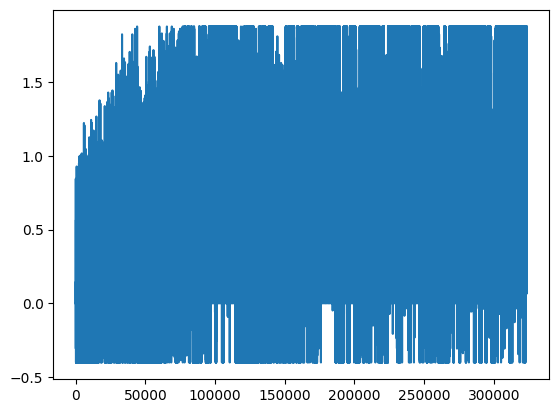

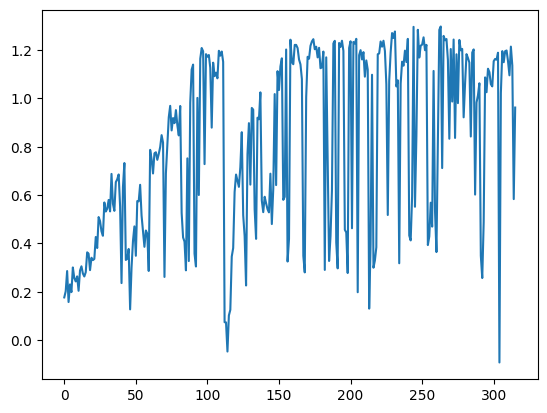

[PPO] Epoch 0: Loss=58.4092, Policy=0.0041, Value=116.8873
[PPO] Epoch 10: Loss=33.2243, Policy=-0.0019, Value=66.5247
[PPO] Epoch 20: Loss=22.3273, Policy=-0.0131, Value=44.7555
[PPO] Epoch 30: Loss=18.3937, Policy=-0.0240, Value=36.9145
Approx KL Learned: 0.0391777940094471
[✅] Actor-Critic checkpoint saved to chkpoint_79.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 80/100 — steps: 4096


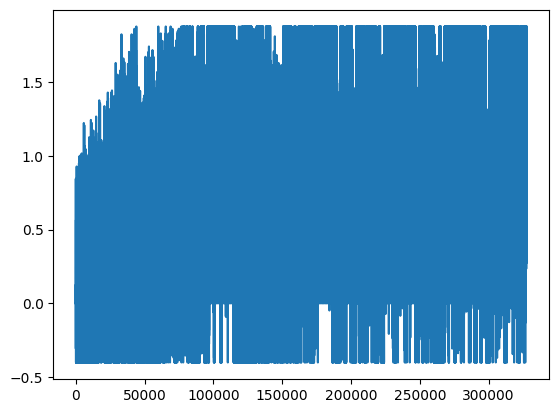

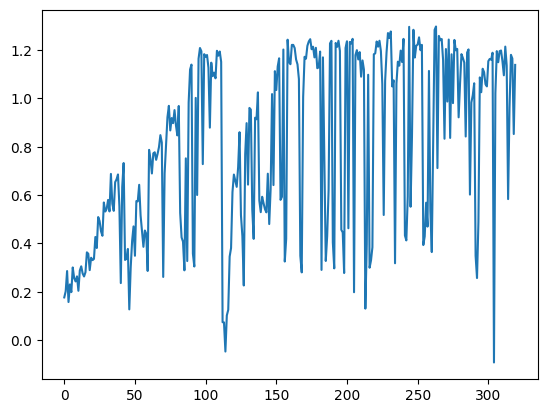

[PPO] Epoch 0: Loss=40.9060, Policy=0.0067, Value=81.8805
[PPO] Epoch 10: Loss=24.3160, Policy=-0.0023, Value=48.7151
[PPO] Epoch 20: Loss=19.0235, Policy=-0.0176, Value=38.1618
[PPO] Epoch 30: Loss=15.2912, Policy=-0.0230, Value=30.7116
Approx KL Learned: 0.038507454097270966
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 81/100 — steps: 4096


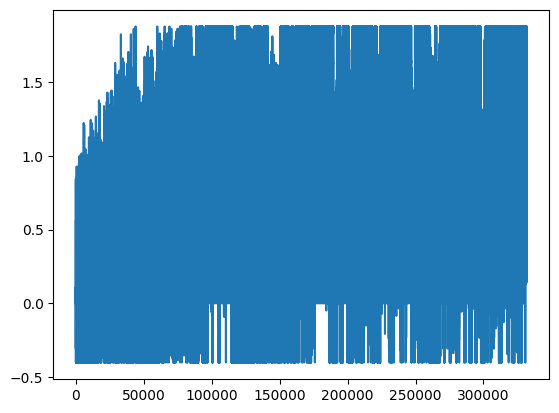

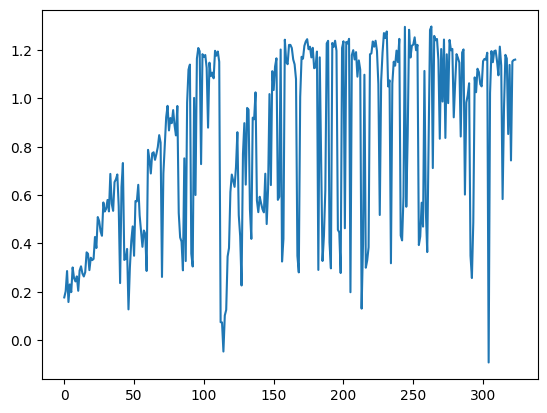

[PPO] Epoch 0: Loss=58.8436, Policy=0.0043, Value=117.7602
[PPO] Epoch 10: Loss=36.0647, Policy=-0.0096, Value=72.2305
[PPO] Epoch 20: Loss=28.9032, Policy=-0.0244, Value=57.9383
[PPO] Epoch 30: Loss=24.4181, Policy=-0.0348, Value=48.9889
Approx KL Learned: 0.043913718312978745
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 82/100 — steps: 4096


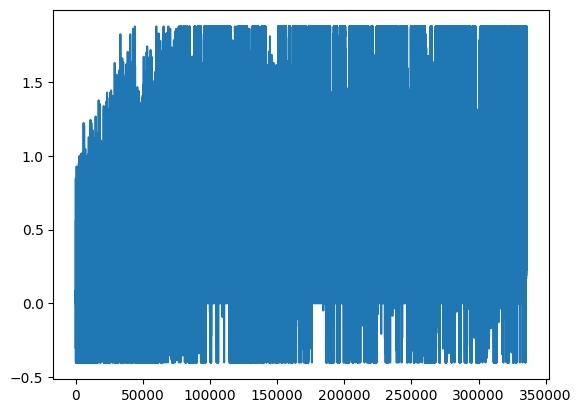

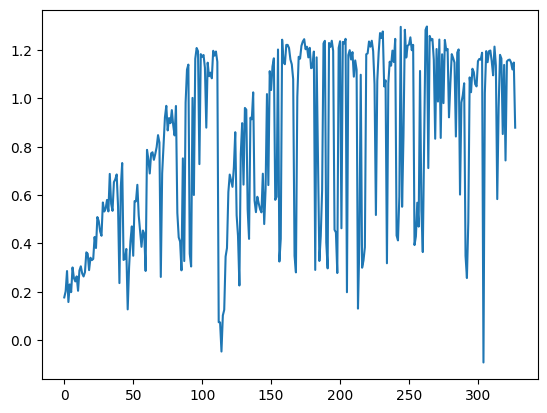

[PPO] Epoch 0: Loss=56.2957, Policy=0.0064, Value=112.6680
[PPO] Epoch 10: Loss=39.3740, Policy=0.0003, Value=78.8348
[PPO] Epoch 20: Loss=31.4386, Policy=-0.0179, Value=62.9962
[PPO] Epoch 30: Loss=23.9943, Policy=-0.0191, Value=48.1127
Approx KL Learned: 0.0271298848092556
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 83/100 — steps: 4096


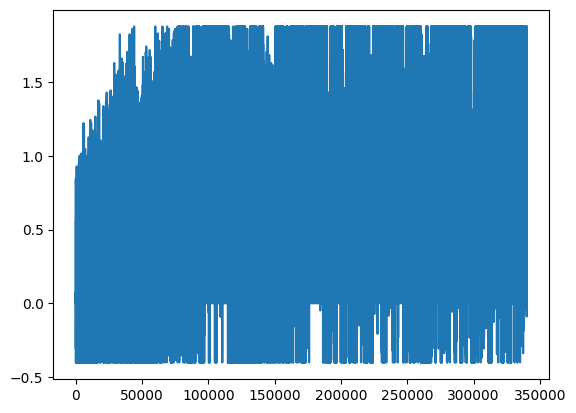

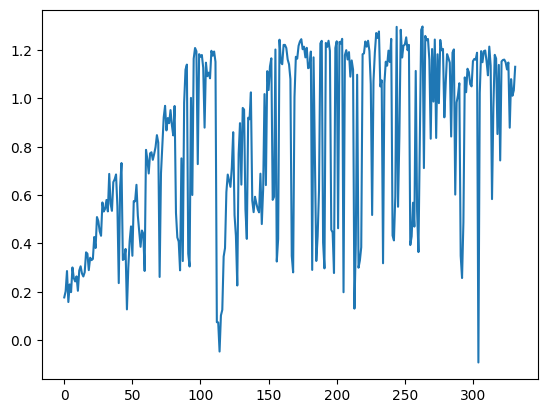

[PPO] Epoch 0: Loss=83.1826, Policy=0.0083, Value=166.4319
[PPO] Epoch 10: Loss=44.4339, Policy=-0.0069, Value=88.9619
[PPO] Epoch 20: Loss=24.1704, Policy=-0.0195, Value=48.4630
[PPO] Epoch 30: Loss=15.9607, Policy=-0.0325, Value=32.0684
Approx KL Learned: 0.04974205419421196
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 84/100 — steps: 4096


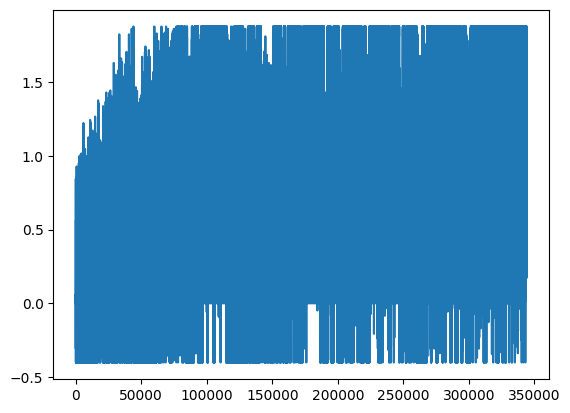

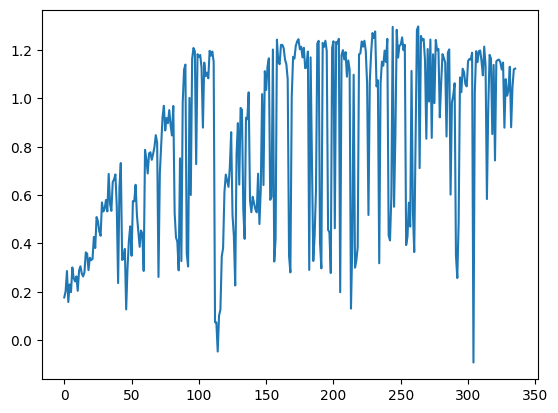

[PPO] Epoch 0: Loss=92.0971, Policy=0.0091, Value=184.2843
[PPO] Epoch 10: Loss=38.5758, Policy=-0.0018, Value=77.2560
[PPO] Epoch 20: Loss=23.7060, Policy=-0.0226, Value=47.5609
[PPO] Epoch 30: Loss=16.0513, Policy=-0.0350, Value=32.2748
Approx KL Learned: 0.07995054125785828
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 85/100 — steps: 4096


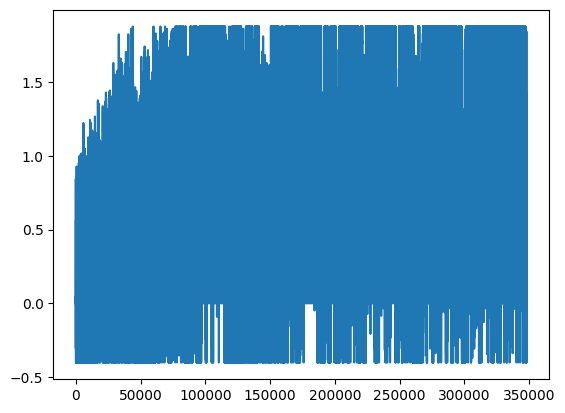

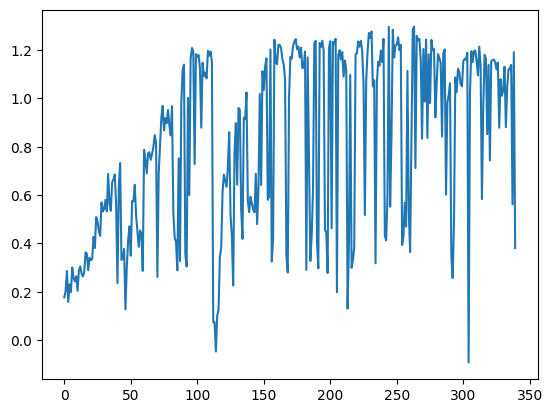

[PPO] Epoch 0: Loss=44.3576, Policy=0.0071, Value=88.7658
[PPO] Epoch 10: Loss=19.6697, Policy=-0.0052, Value=39.4136
[PPO] Epoch 20: Loss=11.6266, Policy=-0.0189, Value=23.3568
[PPO] Epoch 30: Loss=9.5536, Policy=-0.0299, Value=19.2338
Approx KL Learned: 0.05530121549963951
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 86/100 — steps: 4096


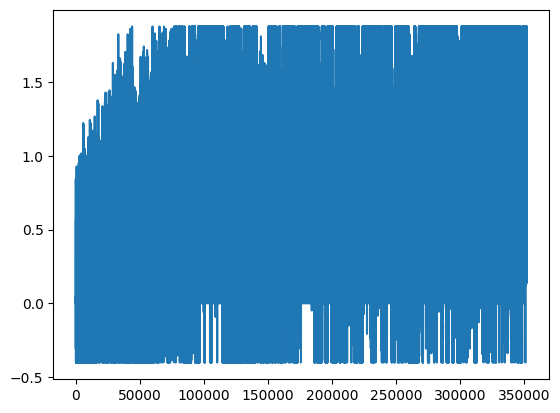

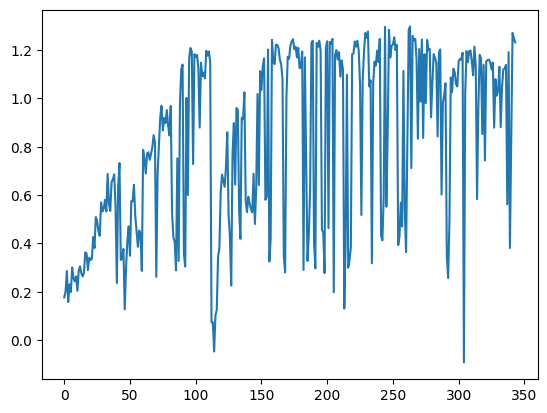

[PPO] Epoch 0: Loss=86.6819, Policy=0.0045, Value=173.4720
[PPO] Epoch 10: Loss=45.7589, Policy=-0.0013, Value=91.6365
[PPO] Epoch 20: Loss=28.2857, Policy=-0.0217, Value=56.7297
[PPO] Epoch 30: Loss=21.4777, Policy=-0.0383, Value=43.1478
Approx KL Learned: 0.05156426876783371
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 87/100 — steps: 4096


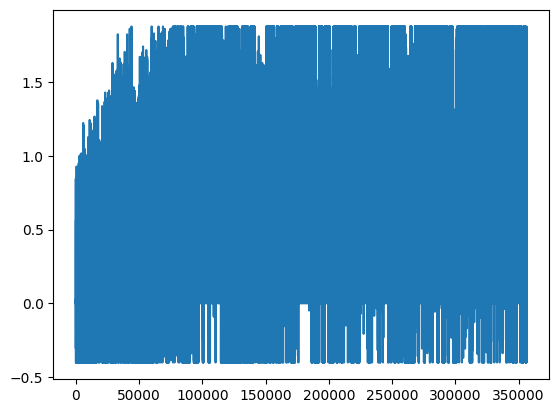

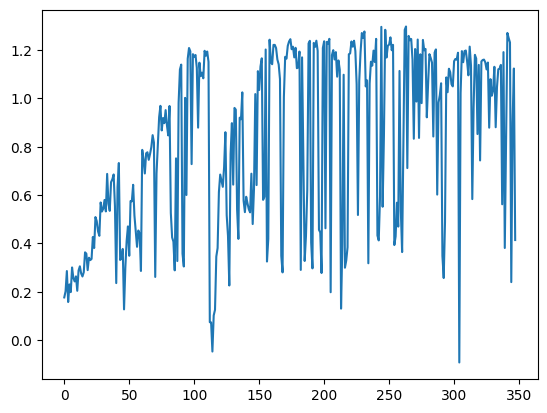

[PPO] Epoch 0: Loss=56.4885, Policy=0.0090, Value=113.0201
[PPO] Epoch 10: Loss=18.6739, Policy=-0.0041, Value=37.4046
[PPO] Epoch 20: Loss=14.7576, Policy=-0.0099, Value=29.5974
[PPO] Epoch 30: Loss=11.8891, Policy=-0.0186, Value=23.8850
Approx KL Learned: 0.05006472393870354
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 88/100 — steps: 4096


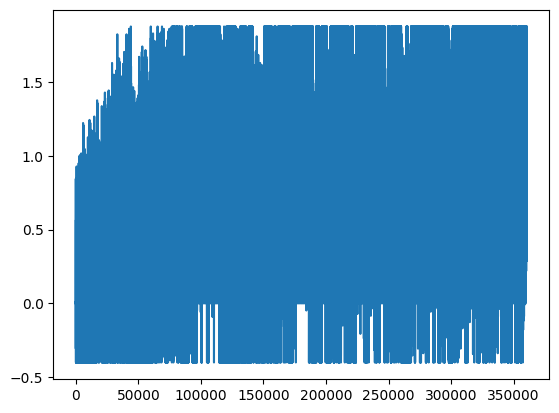

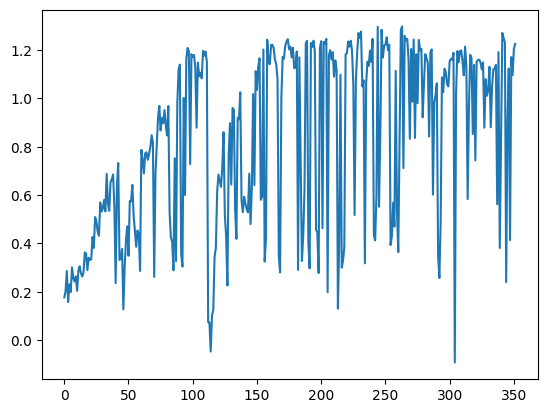

[PPO] Epoch 0: Loss=51.4168, Policy=0.0074, Value=102.8982
[PPO] Epoch 10: Loss=24.9086, Policy=-0.0096, Value=49.8990
[PPO] Epoch 20: Loss=18.1457, Policy=-0.0163, Value=36.4021
[PPO] Epoch 30: Loss=14.7604, Policy=-0.0287, Value=29.6551
Approx KL Learned: 0.037472642958164215
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 89/100 — steps: 4096


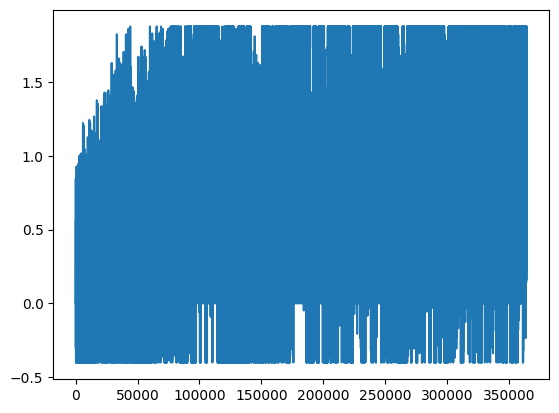

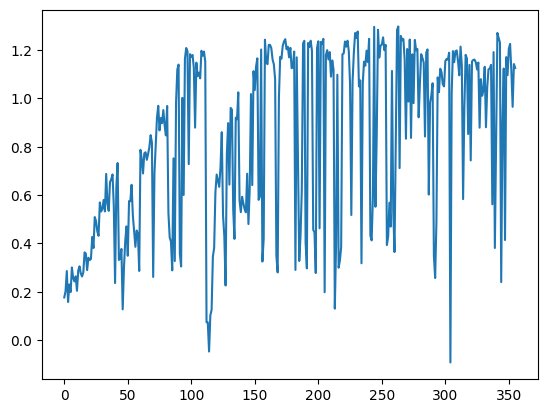

[PPO] Epoch 0: Loss=56.0317, Policy=0.0075, Value=112.1454
[PPO] Epoch 10: Loss=29.8996, Policy=-0.0161, Value=59.9221
[PPO] Epoch 20: Loss=18.6903, Policy=-0.0382, Value=37.5496
[PPO] Epoch 30: Loss=14.3345, Policy=-0.0479, Value=28.8635
Approx KL Learned: 0.06792986392974854
[✅] Actor-Critic checkpoint saved to chkpoint_89.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 90/100 — steps: 4096


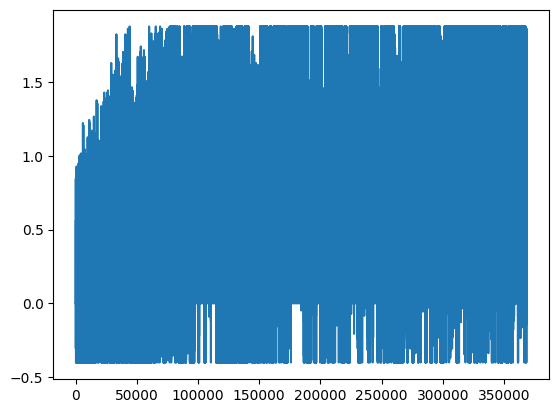

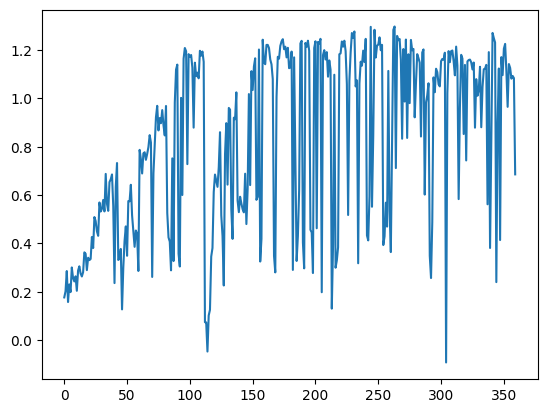

[PPO] Epoch 0: Loss=51.4334, Policy=0.0030, Value=102.9563
[PPO] Epoch 10: Loss=30.8443, Policy=-0.0078, Value=61.7980
[PPO] Epoch 20: Loss=20.8847, Policy=-0.0223, Value=41.9071
[PPO] Epoch 30: Loss=17.1755, Policy=-0.0330, Value=34.5090
Approx KL Learned: 0.032367318868637085
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 91/100 — steps: 4096


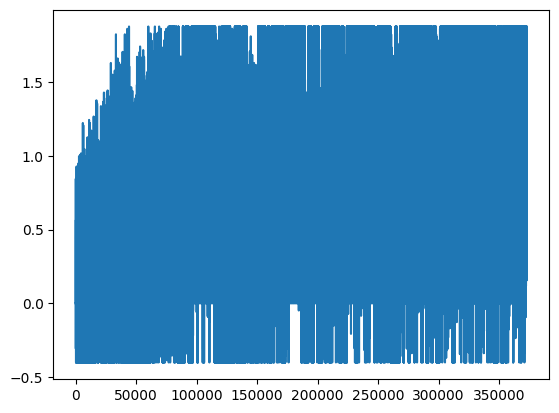

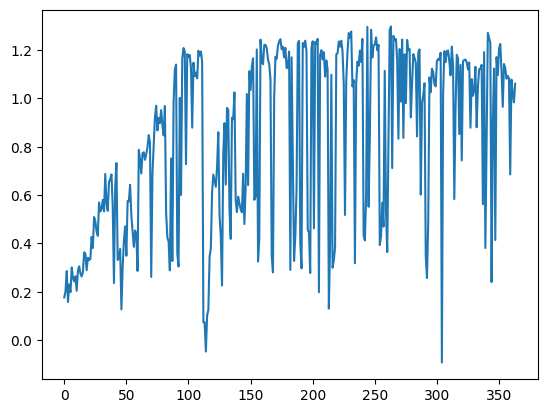

[PPO] Epoch 0: Loss=52.3402, Policy=0.0085, Value=104.7568
[PPO] Epoch 10: Loss=37.1552, Policy=-0.0053, Value=74.4041
[PPO] Epoch 20: Loss=25.7827, Policy=-0.0134, Value=51.6800
[PPO] Epoch 30: Loss=18.6829, Policy=-0.0184, Value=37.4955
Approx KL Learned: 0.03807542473077774
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 92/100 — steps: 4096


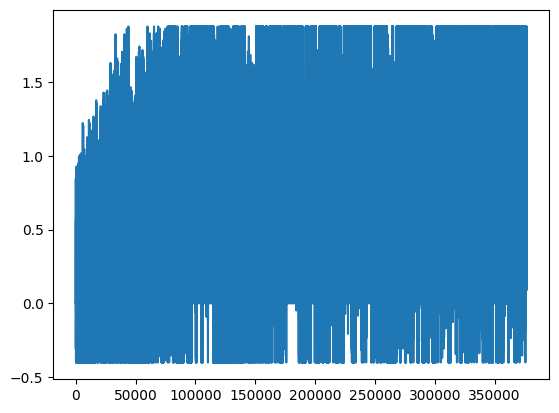

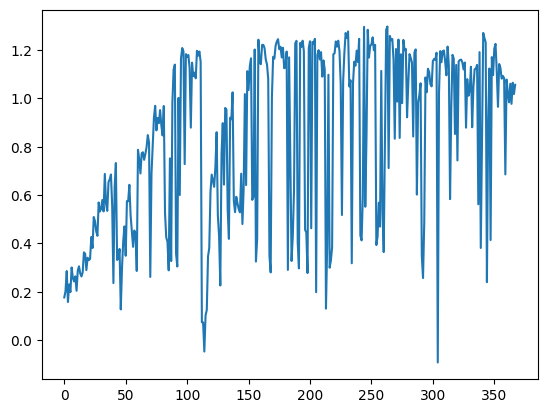

[PPO] Epoch 0: Loss=43.0061, Policy=0.0073, Value=86.0790
[PPO] Epoch 10: Loss=29.5540, Policy=-0.0056, Value=59.1902
[PPO] Epoch 20: Loss=22.5250, Policy=-0.0136, Value=45.1511
[PPO] Epoch 30: Loss=18.1767, Policy=-0.0203, Value=36.4712
Approx KL Learned: 0.03341466933488846
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 93/100 — steps: 4096


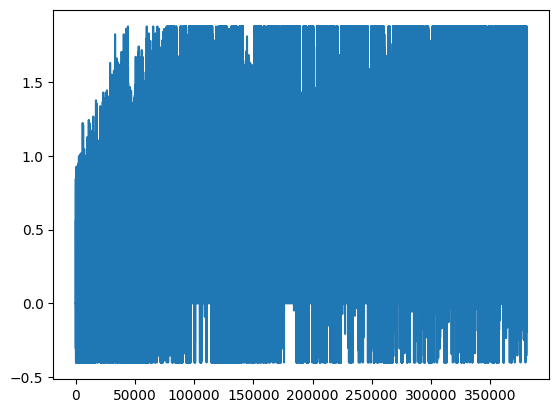

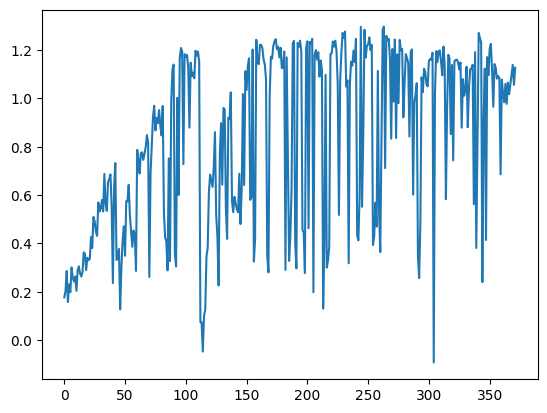

[PPO] Epoch 0: Loss=56.4541, Policy=0.0062, Value=112.9841
[PPO] Epoch 10: Loss=27.5461, Policy=-0.0134, Value=55.1997
[PPO] Epoch 20: Loss=18.3698, Policy=-0.0247, Value=36.8757
[PPO] Epoch 30: Loss=13.8297, Policy=-0.0349, Value=27.8148
Approx KL Learned: 0.03694365546107292
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 94/100 — steps: 4096


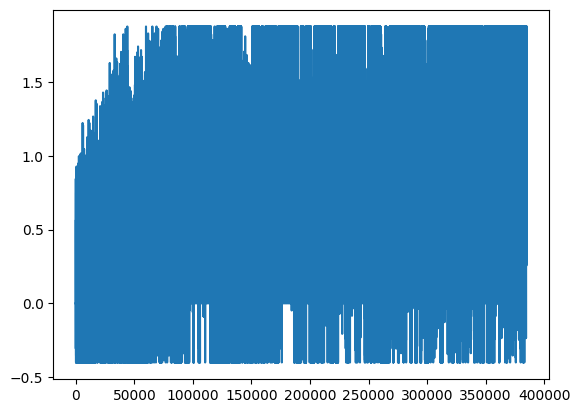

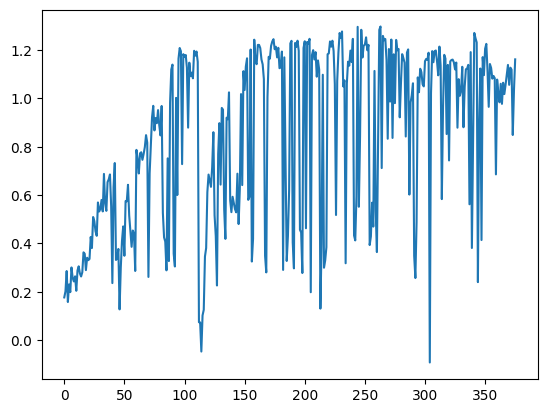

[PPO] Epoch 0: Loss=41.4071, Policy=0.0071, Value=82.8729
[PPO] Epoch 10: Loss=19.2712, Policy=-0.0140, Value=38.6372
[PPO] Epoch 20: Loss=11.6220, Policy=-0.0292, Value=23.3692
[PPO] Epoch 30: Loss=8.1666, Policy=-0.0370, Value=16.4751
Approx KL Learned: 0.035826414823532104
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 95/100 — steps: 4096


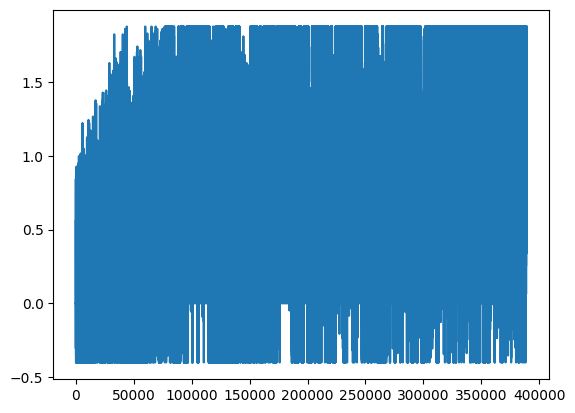

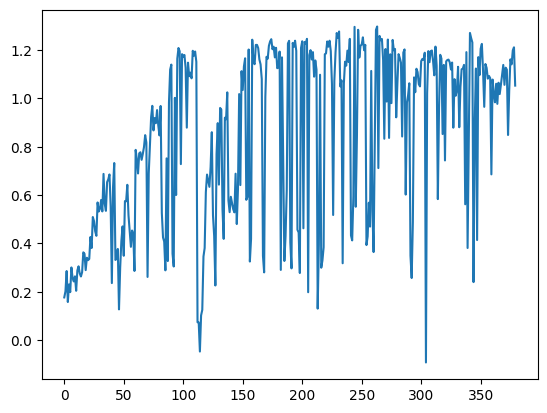

[PPO] Epoch 0: Loss=39.1532, Policy=0.0065, Value=78.3578
[PPO] Epoch 10: Loss=25.5838, Policy=-0.0048, Value=51.2367
[PPO] Epoch 20: Loss=17.1397, Policy=-0.0098, Value=34.3616
[PPO] Epoch 30: Loss=11.8822, Policy=-0.0177, Value=23.8619
Approx KL Learned: 0.02593110129237175
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 96/100 — steps: 4096


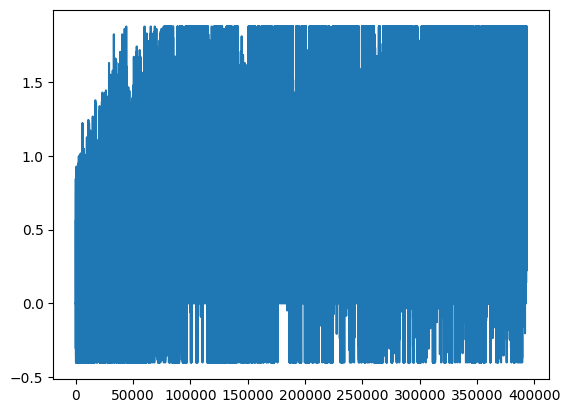

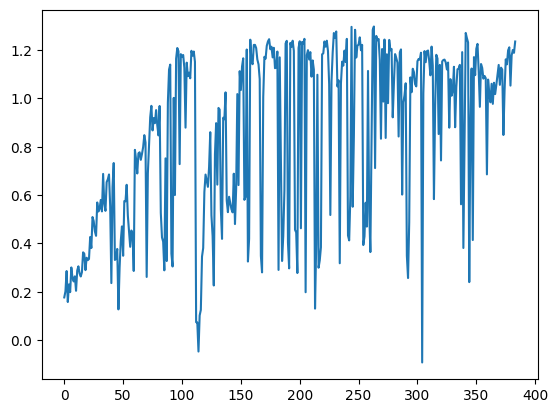

[PPO] Epoch 0: Loss=37.7134, Policy=0.0037, Value=75.4860
[PPO] Epoch 10: Loss=21.3650, Policy=-0.0101, Value=42.8151
[PPO] Epoch 20: Loss=18.0064, Policy=-0.0250, Value=36.1303
[PPO] Epoch 30: Loss=16.1528, Policy=-0.0305, Value=32.4360
Approx KL Learned: 0.040547437965869904
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 97/100 — steps: 4096


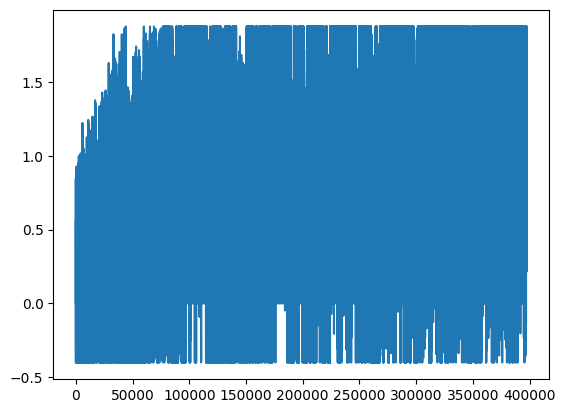

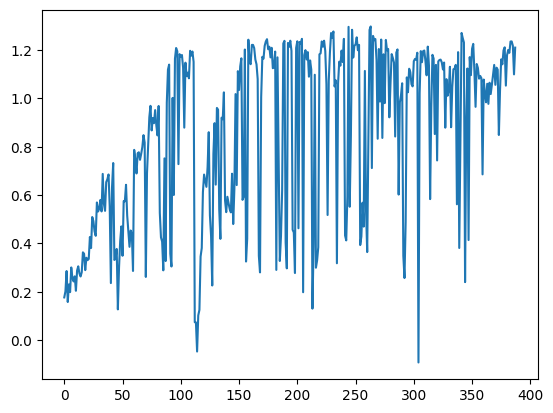

[PPO] Epoch 0: Loss=54.7512, Policy=0.0009, Value=109.5766
[PPO] Epoch 10: Loss=24.3619, Policy=-0.0057, Value=48.8099
[PPO] Epoch 20: Loss=18.9883, Policy=-0.0238, Value=38.0962
[PPO] Epoch 30: Loss=16.3319, Policy=-0.0355, Value=32.8080
Approx KL Learned: 0.03911641240119934
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 98/100 — steps: 4096


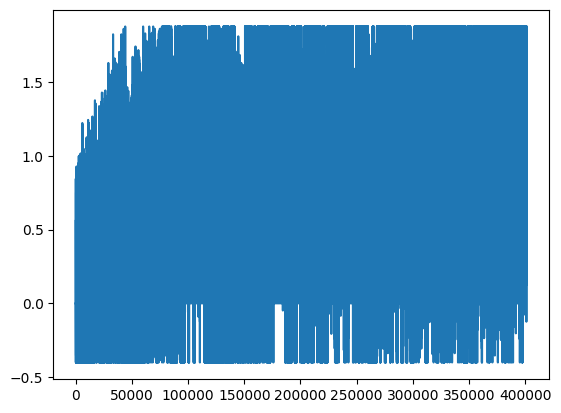

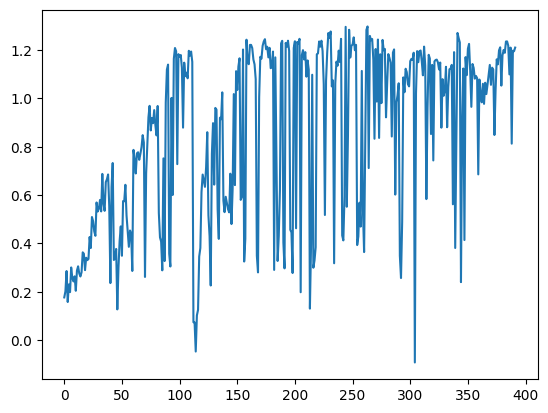

[PPO] Epoch 0: Loss=17.8983, Policy=0.0068, Value=35.8482
[PPO] Epoch 10: Loss=13.2128, Policy=-0.0098, Value=26.5057
[PPO] Epoch 20: Loss=9.2096, Policy=-0.0251, Value=18.5369
[PPO] Epoch 30: Loss=7.3594, Policy=-0.0345, Value=14.8481
Approx KL Learned: 0.06268340349197388
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 99/100 — steps: 4096


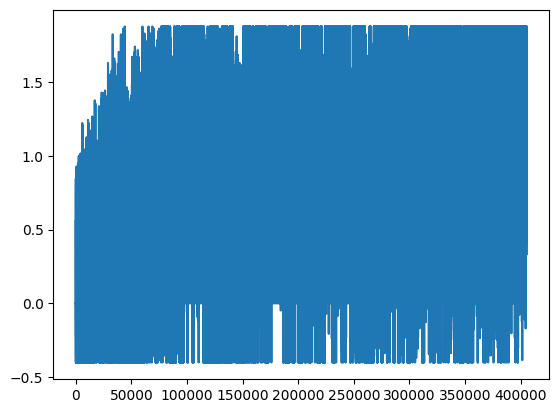

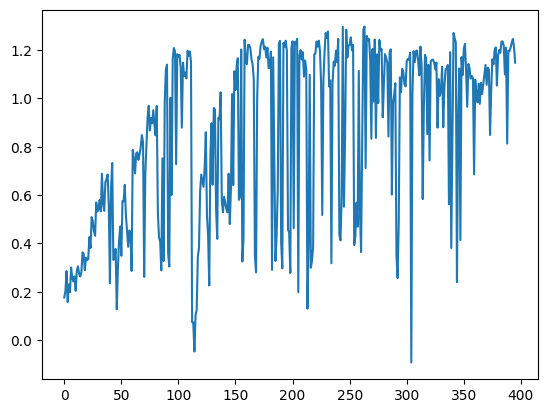

[PPO] Epoch 0: Loss=32.8910, Policy=0.0033, Value=65.8539
[PPO] Epoch 10: Loss=22.6293, Policy=-0.0149, Value=45.3592
[PPO] Epoch 20: Loss=15.0756, Policy=-0.0175, Value=30.2705
[PPO] Epoch 30: Loss=11.1249, Policy=-0.0339, Value=22.3973
Approx KL Learned: 0.0646684393286705
[✅] Actor-Critic checkpoint saved to chkpoint_99.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 100/100 — steps: 4096


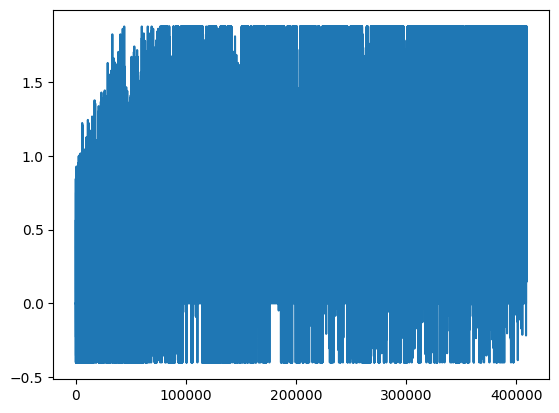

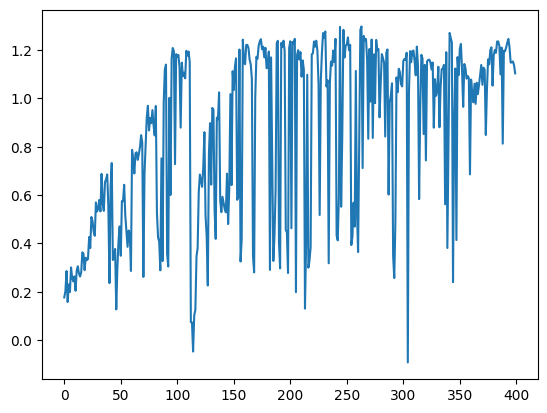

In [11]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 100)

[PPO] Epoch 0: Loss=70.9477, Policy=0.0046, Value=142.0332
[PPO] Epoch 10: Loss=53.0609, Policy=0.0121, Value=106.2433
[PPO] Epoch 20: Loss=49.0273, Policy=-0.0006, Value=98.2034
[PPO] Epoch 30: Loss=44.0378, Policy=-0.0089, Value=88.2390
Approx KL Learned: 0.15264606475830078
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/10 — steps: 4096


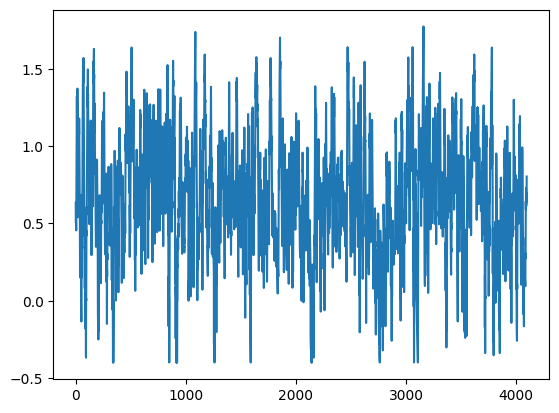

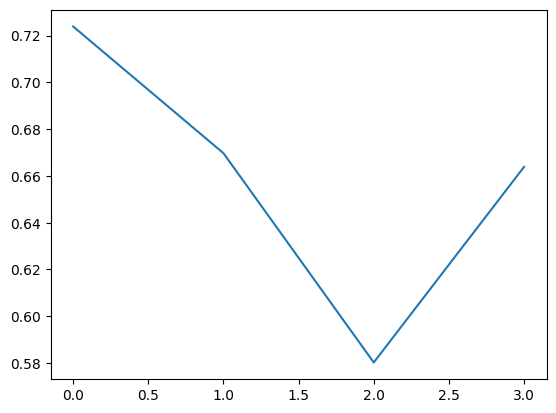

[PPO] Epoch 0: Loss=83.2329, Policy=0.0065, Value=166.6063
[PPO] Epoch 10: Loss=67.4079, Policy=0.0239, Value=134.9081
[PPO] Epoch 20: Loss=56.2694, Policy=0.0060, Value=112.6722
[PPO] Epoch 30: Loss=48.4192, Policy=-0.0032, Value=96.9951
Approx KL Learned: 0.007108601741492748
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/10 — steps: 4096


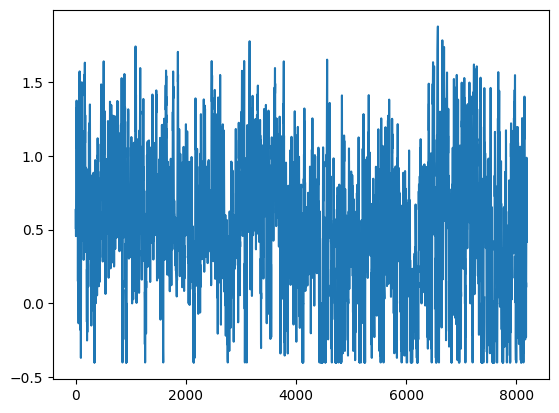

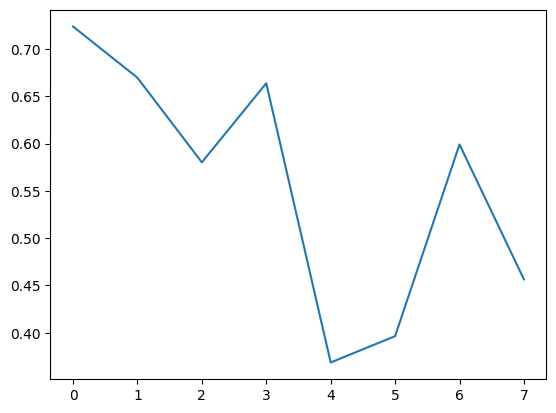

[PPO] Epoch 0: Loss=95.3544, Policy=0.0014, Value=190.8616
[PPO] Epoch 10: Loss=66.4058, Policy=-0.0026, Value=132.9742
[PPO] Epoch 20: Loss=56.9063, Policy=-0.0066, Value=113.9833
[PPO] Epoch 30: Loss=50.0378, Policy=-0.0103, Value=100.2542
Approx KL Learned: 0.019446520134806633
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/10 — steps: 4096


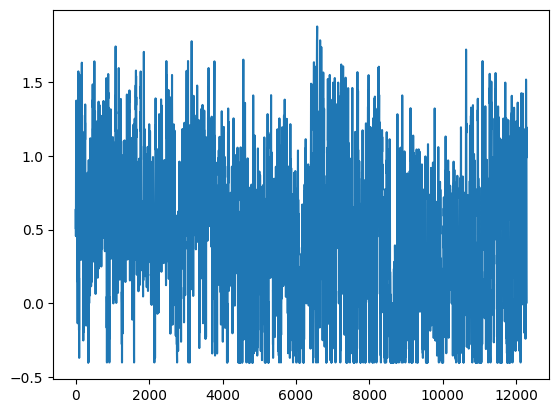

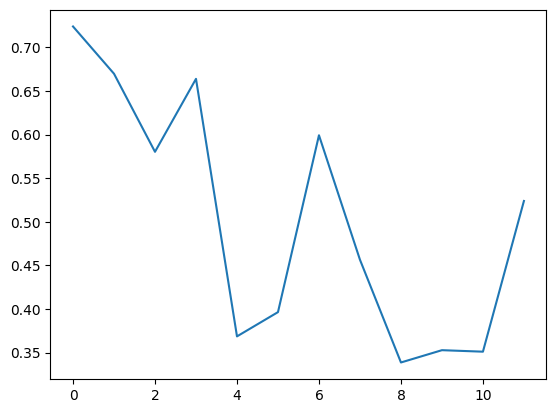

[PPO] Epoch 0: Loss=127.7081, Policy=0.0035, Value=255.5477
[PPO] Epoch 10: Loss=90.1544, Policy=-0.0041, Value=180.4543
[PPO] Epoch 20: Loss=68.3609, Policy=-0.0111, Value=136.8856
[PPO] Epoch 30: Loss=61.7626, Policy=-0.0176, Value=123.7048
Approx KL Learned: 0.027132103219628334
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/10 — steps: 4096


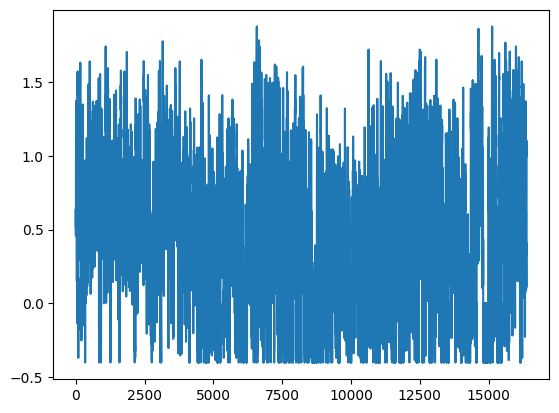

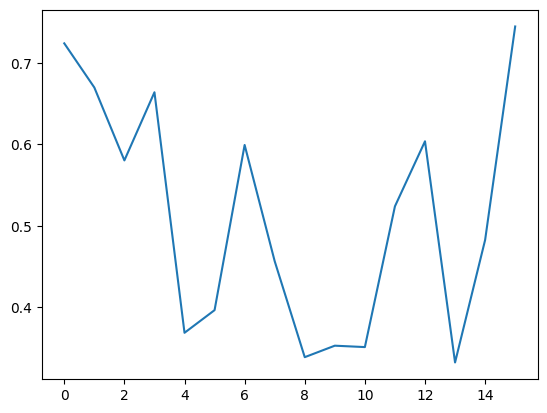

[PPO] Epoch 0: Loss=89.5451, Policy=0.0041, Value=179.2246
[PPO] Epoch 10: Loss=65.9473, Policy=-0.0013, Value=132.0418
[PPO] Epoch 20: Loss=44.1483, Policy=-0.0116, Value=88.4620
[PPO] Epoch 30: Loss=36.2645, Policy=-0.0108, Value=72.6971
Approx KL Learned: 0.07331935316324234
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/10 — steps: 4096


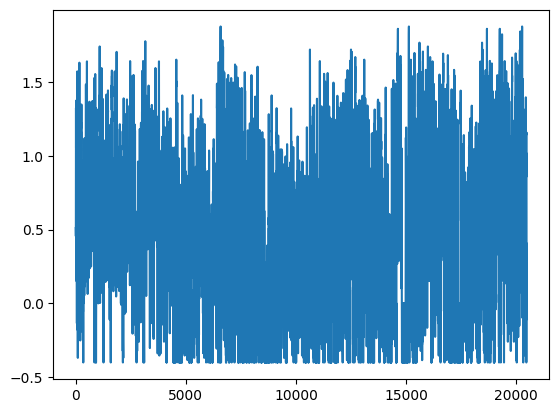

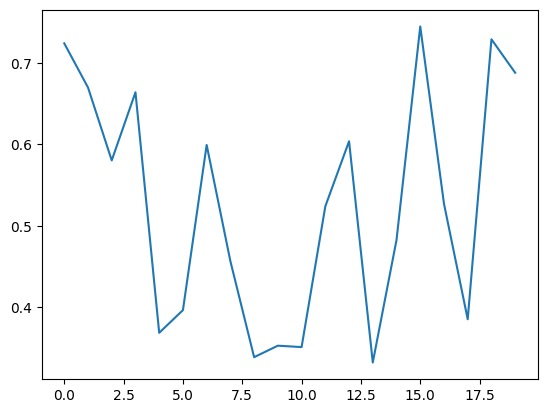

[PPO] Epoch 0: Loss=100.9363, Policy=0.0042, Value=202.0171
[PPO] Epoch 10: Loss=78.9308, Policy=-0.0071, Value=158.0267
[PPO] Epoch 20: Loss=68.9122, Policy=-0.0140, Value=138.0046
[PPO] Epoch 30: Loss=63.6046, Policy=-0.0211, Value=127.4019
Approx KL Learned: 0.032076217234134674
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/10 — steps: 4096


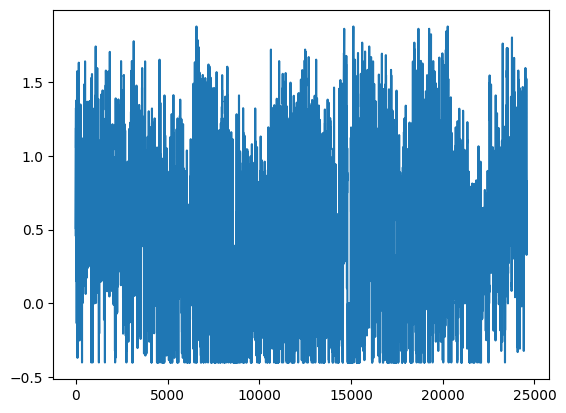

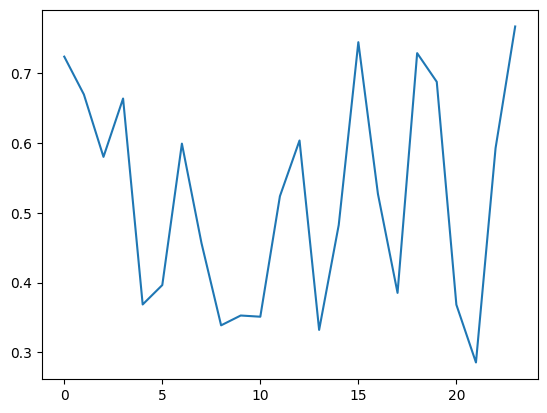

[PPO] Epoch 0: Loss=83.1606, Policy=0.0046, Value=166.4530
[PPO] Epoch 10: Loss=66.7907, Policy=-0.0051, Value=133.7293
[PPO] Epoch 20: Loss=57.9218, Policy=-0.0119, Value=116.0026
[PPO] Epoch 30: Loss=49.2838, Policy=-0.0005, Value=98.7088
Approx KL Learned: 0.04188523441553116
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/10 — steps: 4096


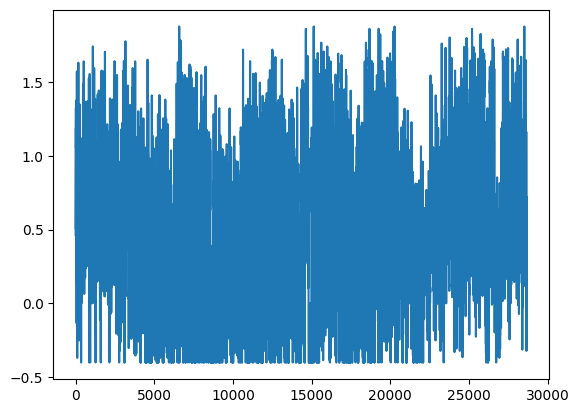

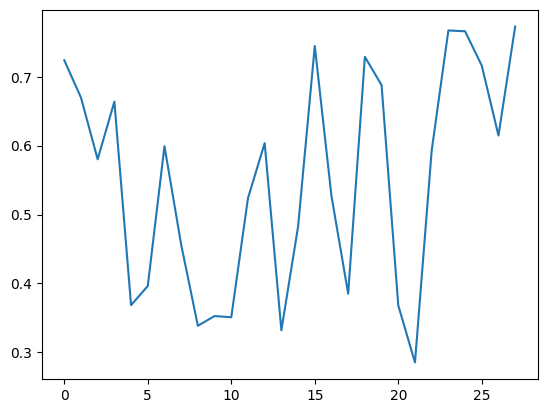

[PPO] Epoch 0: Loss=71.4654, Policy=0.0073, Value=143.0497
[PPO] Epoch 10: Loss=53.0982, Policy=0.0187, Value=106.2891
[PPO] Epoch 20: Loss=47.0114, Policy=-0.0076, Value=94.1702
[PPO] Epoch 30: Loss=44.7595, Policy=0.0093, Value=89.6246
Approx KL Learned: 0.1447896957397461
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/10 — steps: 4096


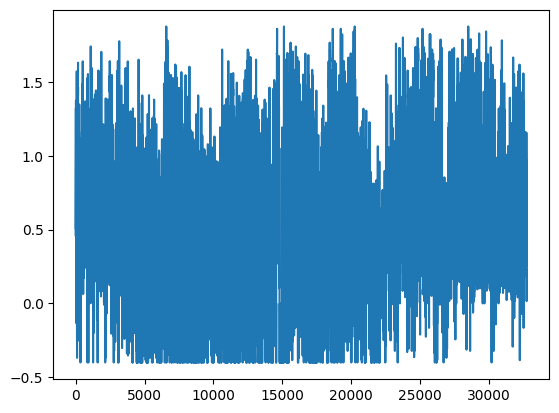

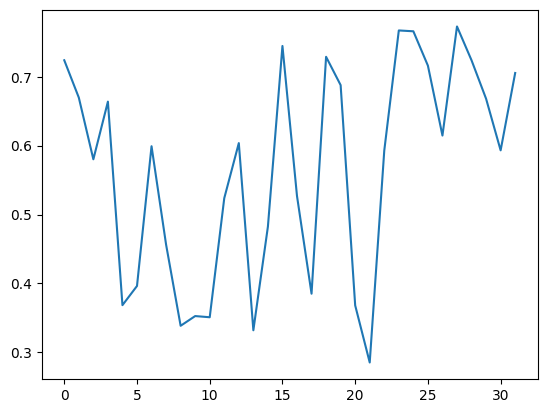

[PPO] Epoch 0: Loss=72.9468, Policy=0.0021, Value=146.0426
[PPO] Epoch 10: Loss=45.2135, Policy=-0.0128, Value=90.6110
[PPO] Epoch 20: Loss=37.4766, Policy=-0.0142, Value=75.1373
[PPO] Epoch 30: Loss=32.3875, Policy=-0.0186, Value=64.9706
Approx KL Learned: 0.024285409599542618
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/10 — steps: 4096


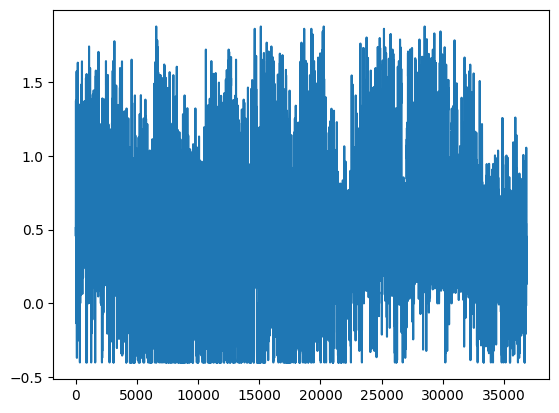

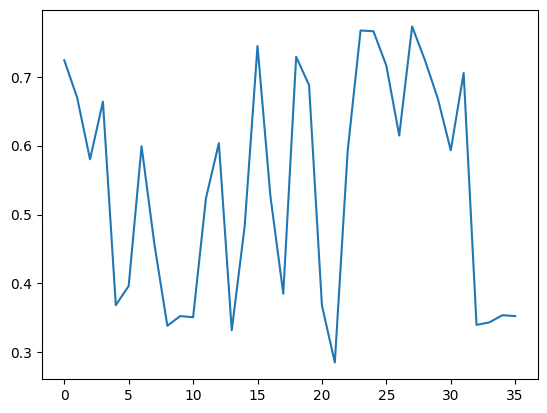

[PPO] Epoch 0: Loss=56.5988, Policy=0.0016, Value=113.3447
[PPO] Epoch 10: Loss=40.8591, Policy=-0.0119, Value=81.8905
[PPO] Epoch 20: Loss=33.1732, Policy=-0.0191, Value=66.5334
[PPO] Epoch 30: Loss=25.4240, Policy=-0.0307, Value=51.0571
Approx KL Learned: 0.026637090370059013
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/10 — steps: 4096


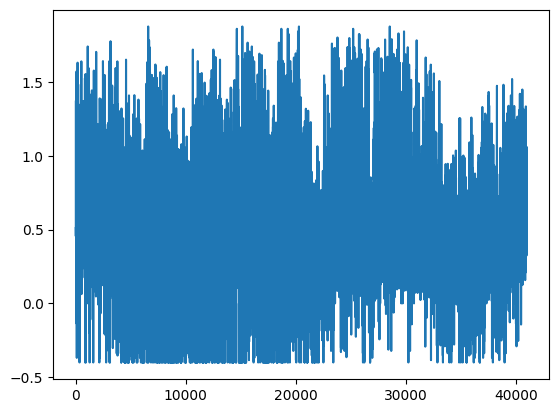

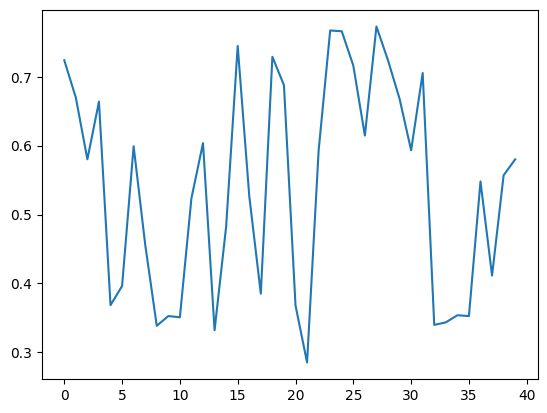

In [10]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 10)

In [14]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=256
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.6, 0.1, 0.3]))
    print(dist.probs)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
print(init_pos)
inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic)

{'x': 5.583041667938232, 'y': 0.9009993672370911, 'z': 4.5739312171936035}
tensor([0.3002, 0.1449, 0.5549], device='cuda:0')
tensor([0.3265, 0.1453, 0.5282], device='cuda:0')
tensor([0.3583, 0.0920, 0.5498], device='cuda:0')
tensor([0.7804, 0.0666, 0.1530], device='cuda:0')
tensor([0.6065, 0.2854, 0.1081], device='cuda:0')
tensor([0.8517, 0.0458, 0.1025], device='cuda:0')
tensor([0.8232, 0.0350, 0.1418], device='cuda:0')
tensor([0.2768, 0.0598, 0.6634], device='cuda:0')
tensor([0.2517, 0.0648, 0.6835], device='cuda:0')
tensor([0.7993, 0.0469, 0.1537], device='cuda:0')
tensor([0.8902, 0.0284, 0.0814], device='cuda:0')
tensor([0.6803, 0.0700, 0.2497], device='cuda:0')
tensor([0.9403, 0.0234, 0.0362], device='cuda:0')
tensor([0.8999, 0.0318, 0.0683], device='cuda:0')
tensor([0.8741, 0.0294, 0.0965], device='cuda:0')
tensor([0.6105, 0.2397, 0.1498], device='cuda:0')
tensor([0.6724, 0.1470, 0.1806], device='cuda:0')
tensor([0.7598, 0.1591, 0.0811], device='cuda:0')
tensor([0.6818, 0.1138, 0

[[5.583041667938232, 4.5739312171936035],
 [5.583041667938232, 4.5739312171936035],
 [5.583041667938232, 4.5739312171936035],
 [5.583041667938232, 4.5739312171936035],
 [5.583041667938232, 4.5739312171936035],
 [5.583041667938232, 4.5739312171936035],
 [5.333041667938232, 4.5739312171936035],
 [5.333041667938232, 4.5739312171936035],
 [5.116535186767578, 4.6989312171936035],
 [5.116535186767578, 4.6989312171936035],
 [4.866535186767578, 4.6989312171936035],
 [4.616535186767578, 4.6989312171936035],
 [4.366535186767578, 4.6989312171936035],
 [4.116535186767578, 4.6989312171936035],
 [3.866535186767578, 4.6989312171936035],
 [3.866535186767578, 4.6989312171936035],
 [3.650028944015503, 4.5739312171936035],
 [3.650028944015503, 4.5739312171936035],
 [3.650028944015503, 4.5739312171936035],
 [3.4335227012634277, 4.4489312171936035],
 [3.2170164585113525, 4.3239312171936035],
 [3.2170164585113525, 4.3239312171936035],
 [2.9670164585113525, 4.3239312171936035],
 [2.7170164585113525, 4.323931

In [34]:
!pip install imageio imageio-ffmpeg

In [9]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [10]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.84921875
Rand: 0.790966796875
Policy: 0.867724609375
Rand: 0.836279296875
Policy: 0.835107421875
Rand: 0.752294921875
Policy: 0.83193359375
Rand: 0.7958984375
Policy: 0.868505859375
Rand: 0.871484375


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

In [20]:
controller.stop()